# USA Car Accidents Severity Prediction

# 1) PREPROCESSING

In [1]:
# ! pip install statsmodels
# ! pip install tensorflow
# ! pip install scipy
# ! pip install datetime

In [2]:
import os
import io
import re
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from scipy.stats import chi2_contingency, chi2
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import scipy.stats as stats

## 1.1) Loading the Dataset

In [3]:
dataf = pd.read_csv('US_Accidents_March23.csv')
display(dataf.head(10))

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


## 1.2) Reporting Sources
    
These data came from two sources, *MapQuest* and *Bing*, both of which report severity level but in a different way.

We decided to select *MapQuest* because serious accidents are we really care about and the sparse data of such accidents is the reality we have to confront.

So we drop the data points reported from *Bing* and the 'Source' column as well.

In [4]:
df = dataf[dataf['Source'] == 'Source1']
df = df.drop(columns=['Source'])

## 1.3) Removing Useless Features
- The 'ID' feature doesn’t provide useful information about the accidents.  
- The features `Distance(mi)`, `End_Time`, `End_Lat`, and `End_Lng` can only be collected after an accident has occurred, so they can't help predict serious accidents.  
- Additionally, the `Description` feature already has relevant points of interest extracted by the dataset creators. We remove these features.
- We also drop `Zipcode`, `Timezone`, `Wind_Chill(F)`, `Wind_Direction` and `Weather_Timestamp` columns since we don't want to perform hypothesis testing on these columns.

In [5]:
print(df.columns)

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [6]:
df = df.drop(['ID','Description','Distance(mi)', 'End_Time','End_Lat', 'End_Lng',
              'Zipcode', 'Timezone', 'Weather_Timestamp',
              'Wind_Chill(F)', 'Wind_Direction'], axis=1)

Viewing the categorical features.

In [7]:
categorical_names = ['Country', 'Amenity', 'Bump', 'Crossing', 
             'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 
             'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

print("Unique count of categorical features:\n")
for i in categorical_names:
  print(i,"-", df[i].unique().size)

Unique count of categorical features:

Country - 1
Amenity - 2
Bump - 2
Crossing - 2
Give_Way - 2
Junction - 2
No_Exit - 2
Railway - 2
Roundabout - 2
Station - 2
Stop - 2
Traffic_Calming - 2
Traffic_Signal - 2
Turning_Loop - 1
Sunrise_Sunset - 3
Civil_Twilight - 3
Nautical_Twilight - 3
Astronomical_Twilight - 3


Drop 'Country' and 'Turning_Loop' because they have only one class.

In [8]:
df = df.drop(['Country','Turning_Loop'], axis=1)

## 1.4) Processing Categorical Features
If we look at categorical features closely, we will find confusing values in 'Weather_Condition' and 'Wind_Direction'.

### Weather Condition
Weather-related vehicle accidents cause more annual fatalities than large-scale disasters. The Road Weather Management Program reports that most such crashes occur on wet pavement and during rainfall, with winter conditions and fog also contributing significantly. To analyze these three weather conditions, we will first examine the 'Weather_Condition' feature.

In [9]:
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split("!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Duststorm', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Nearby', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Volcanic

Create features for some common weather conditions and drop 'Weather_Condition' then.

In [10]:
# Clear Weather
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear|Fair', case=False, na=False), True, False)

# Cloudy Weather
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast|Scattered Clouds|Partly Cloudy|Mostly Cloudy', case=False, na=False), True, False)

# Light Rain
df['Light_Rain'] = np.where(df['Weather_Condition'].str.contains('Light Rain|Drizzle|Rain Showers|Showers in the Vicinity|Light Drizzle|Sleet|Light Sleet', case=False, na=False), True, False)

# Heavy Rain
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms|Thunderstorm|Heavy Rain Shower|Heavy Rain Showers|Heavy Sleet', case=False, na=False), True, False)

# Thunderstorm (General Category)
df['Thunderstorm'] = np.where(df['Weather_Condition'].str.contains('T-Storm|Thunderstorm|Thunder|Thunder in the Vicinity|Light Thunderstorms', case=False, na=False), True, False)

# Snow / Ice Conditions
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Ice Pellets|Wintry Mix|Snow Grains|Snow Nearby|Snow Shower|Light Ice Pellets', case=False, na=False), True, False)

# Heavy Snow
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na=False), True, False)

# Fog / Haze / Mist
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog|Haze|Mist|Partial Fog|Shallow Fog|Patches of Fog|Light Fog|Light Haze', case=False, na=False), True, False)

# Dust / Sand / Ash
df['Dust'] = np.where(df['Weather_Condition'].str.contains('Dust|Sand|Volcanic Ash|Widespread Dust|Duststorm|Dust Whirls|Dust Whirls Nearby|Dust Whirlwinds', case=False, na=False), True, False)

# Windy Conditions
df['Wind'] = np.where(df['Weather_Condition'].str.contains('Windy|Blowing|Low Drifting|Drifting Snow', case=False, na=False), True, False)

# Hail
df['Hail'] = np.where(df['Weather_Condition'].str.contains('Hail|Small Hail', case=False, na=False), True, False)

# Tornado
df['Tornado'] = np.where(df['Weather_Condition'].str.contains('Tornado|Funnel Cloud', case=False, na=False), True, False)

# Smoke (Separate Category)
df['Smoke'] = np.where(df['Weather_Condition'].str.contains('Smoke', case=False, na=False), True, False)

In [11]:
# Define the list of new weather categories
weather = ['Clear', 'Cloud', 'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog', 'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke']

# Initialize columns with False for each weather category, including handling missing values
for i in weather:
    df[i] = np.where(df['Weather_Condition'].isnull(), False, df[i].astype('bool'))

# Drop the original 'Weather_Condition' column
df = df.drop(['Weather_Condition'], axis=1)

## 1.5) Fixing Datetime Format

We map 'Start_Time' to 'Year', 'Month', 'Weekday', 'Day' (in a year), 'Hour', and 'Minute' (in a day).

In [12]:
# Remove trailing nanoseconds (if any) in 'Start_Time' columns
df['Start_Time'] = df['Start_Time'].apply(lambda x: re.sub(r"\.0+$", "", str(x)) if pd.notnull(x) else x)

# Convert the cleaned columns to datetime format
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='raise')

# Extract components from 'Start_Time' and create new columns
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Weekday'] = df['Start_Time'].dt.weekday  # 0=Monday, 6=Sunday
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour
df['Minute'] = df['Start_Time'].dt.minute

# Display the new columns to verify
df[['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']].head()

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
3402762,2016-02-08 00:37:08,2016,2,0,8,0,37
3402763,2016-02-08 05:56:20,2016,2,0,8,5,56
3402764,2016-02-08 06:15:39,2016,2,0,8,6,15
3402765,2016-02-08 06:15:39,2016,2,0,8,6,15
3402766,2016-02-08 06:51:45,2016,2,0,8,6,51


In [13]:
df_with_missing_data = df.copy()

# 2) HANDLING MISSING DATA


## 2.1) Separate Features
Add a new feature for missing values in 'Precipitation(in)' and replace missing values with median.


In [14]:
df = df.drop(df[(df['Severity'] == 2) & (df['Precipitation(in)'].isnull())].index)
df['Precipitation_NA'] = 0
df.loc[df['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())

<a id="2.3"></a>
## 2.2) Drop NaN
The counts of missing values in some features are much smaller compared to the total sample. It is convenient to drop rows with missing values in these columns.

Drop NAs by these features:

1. 'City'
2. 'Zipcode'
3. 'Airport_Code'
4. 'Sunrise_Sunset'
5. 'Civil_Twilight'
6. 'Nautical_Twilight'
7. 'Astronomical_Twilight'

In [15]:
df = df.dropna(subset=['City','Airport_Code',
                       'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])

<a id="2.4"></a>
## 2.3) Value Imputation
Rest of the columns only have small missing parts that can be filled.

### Continuous Weather Data
Continuous weather features with missing values:

1. Temperature(F)

2. Humidity(%)

3. Pressure(in)

4. Visibility(mi)

5. Wind_Speed(mph)

The imputation approach involves grouping the data by 'Airport_Code' to ensure geographical relevance, as the weather data originates from airport weather stations, and by 'Start_Month' for computational efficiency and better data retention. Missing values in continuous weather features are then filled using the median of the corresponding groups, providing a robust estimate that is less influenced by outliers. This is implemented through code that applies a lambda function to the grouped DataFrame, effectively filling in missing values with the calculated median for each feature.

In [16]:
Weather_data = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

print("The number of remaining missing values: ")
for feature in Weather_data:
    # Group by 'Airport_Code' and 'Month' and calculate the median within each group
    median_values = df.groupby(['Airport_Code', 'Month'])[feature].transform('median')
    
    # Fill NaNs in each feature column with the calculated median value
    df[feature] = df[feature].fillna(median_values)
    
    # Output the number of remaining NaN values for each feature
    print(f"{feature} : {df[feature].isnull().sum()}")

The number of remaining missing values: 
Temperature(F) : 560
Humidity(%) : 568
Pressure(in) : 524
Visibility(mi) : 6529
Wind_Speed(mph) : 6194


There still are some missing values in the dataset, we just drop these rows for simplicity.

In [17]:
df = df.dropna(subset=Weather_data)
df = pd.concat([df[df['Severity'] == 1], df[df['Severity'] == 2].sample(n=300000, random_state=42), df[df['Severity'] == 3], df[df['Severity'] == 4]])

In [18]:
### Print the cols which have missing values
print("Columns with missing values: ")
print(df_with_missing_data.columns[df_with_missing_data.isnull().any()])



Columns with missing values: 
Index(['Street', 'City', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')


In [19]:
df_with_missing_data.shape

(4325632, 50)

# 3) Exploratory Data Analysis

In [20]:
print("The shape of our dataset is: ", df.shape)

The shape of our dataset is:  (673653, 51)


## 3.1) Distribution of Accident Severity

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/26877047.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette='viridis')


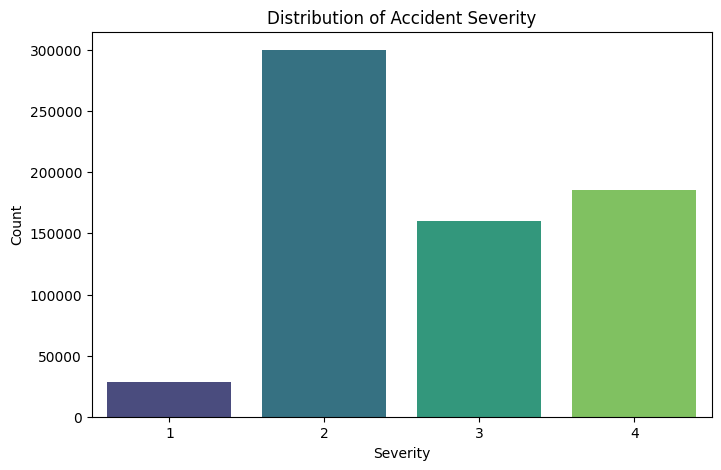

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Severity', data=df, palette='viridis')
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

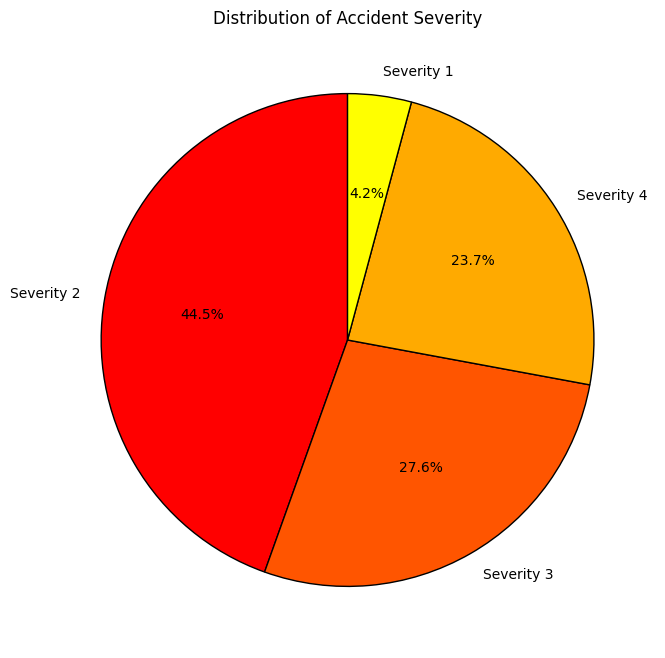

In [22]:
# plot pie chart for the distribution of accident severity
plt.figure(figsize=(8, 8))
df['Severity'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='autumn', wedgeprops={'edgecolor': 'black'}, labels=['Severity 2', 'Severity 3', 'Severity 4', 'Severity 1'])
plt.title("Distribution of Accident Severity")
plt.ylabel('')
plt.show()

In [23]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Street', 'City',
       'County', 'State', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud',
       'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog',
       'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke', 'Year', 'Month', 'Weekday',
       'Day', 'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/869809329.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Severity', y='Temperature(F)', palette="viridis")


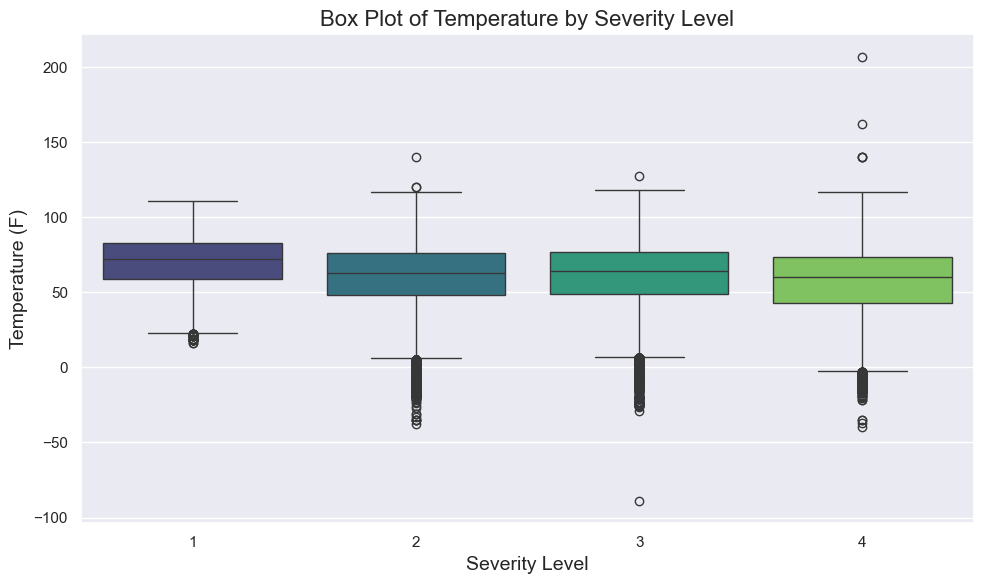

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a colorful style for seaborn
sns.set(style="darkgrid")

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the box plot with a "Spectral" color palette for vibrant colors
sns.boxplot(data=df, x='Severity', y='Temperature(F)', palette="viridis")

# Set title and labels
plt.title("Box Plot of Temperature by Severity Level", fontsize=16)
plt.xlabel("Severity Level", fontsize=14)
plt.ylabel("Temperature (F)", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


## 3.2) Accidents by Weather Conditions

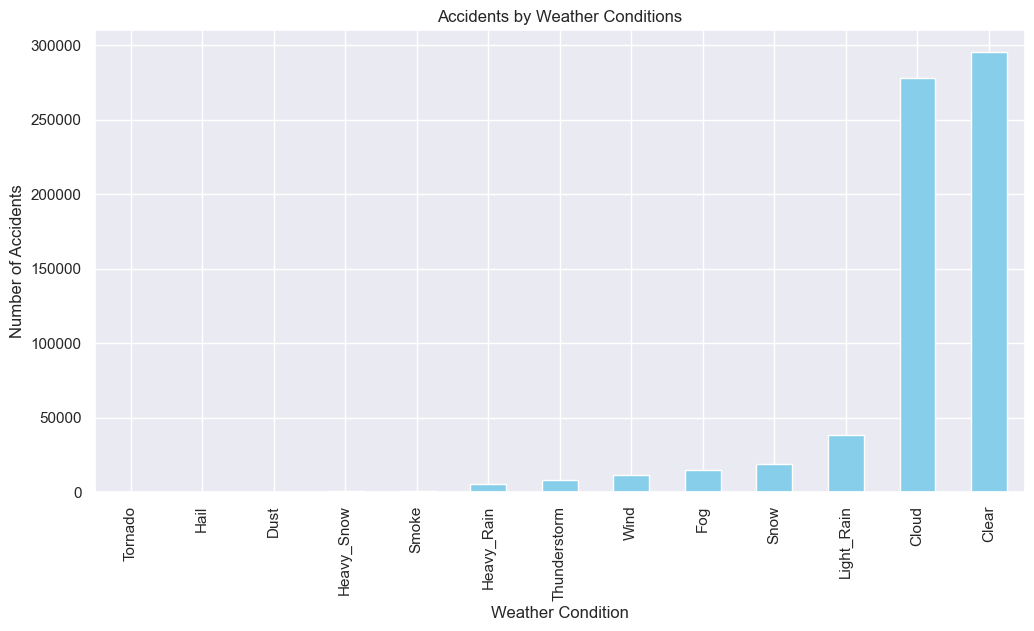

In [25]:
# Melt the weather-related columns for plotting
weather_columns = ['Clear', 'Cloud', 'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog', 'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke']
weather_data = df[weather_columns].melt(var_name="Weather_Condition", value_name="Presence")
weather_counts = weather_data[weather_data['Presence']].groupby('Weather_Condition').size()

# Plot accident counts by weather condition
plt.figure(figsize=(12, 6))
weather_counts.sort_values().plot(kind='bar', color='skyblue')
plt.title("Accidents by Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.show()

## 3.3) Temporal Patterns: Accidents by Hour

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/3038877931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='plasma')


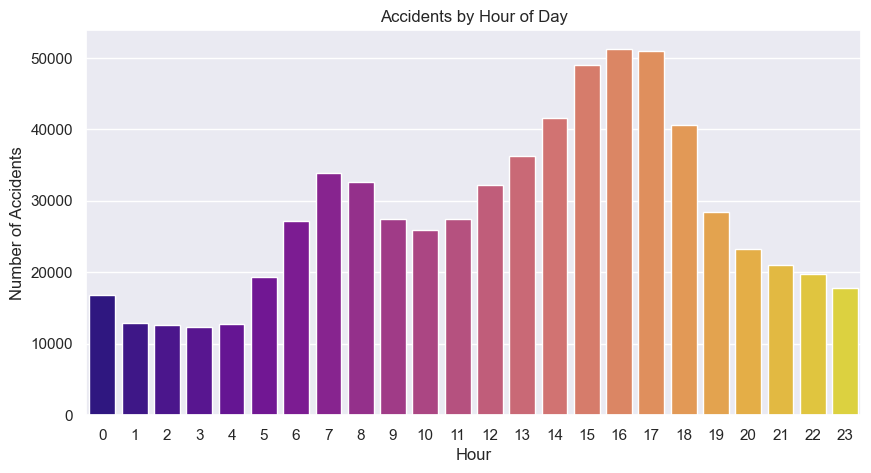

In [26]:
# Plot accident count by hour
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df, palette='plasma')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.show()

## 3.4) Accidents by Day of the Week

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/560656328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weekday', data=df, palette='cividis')


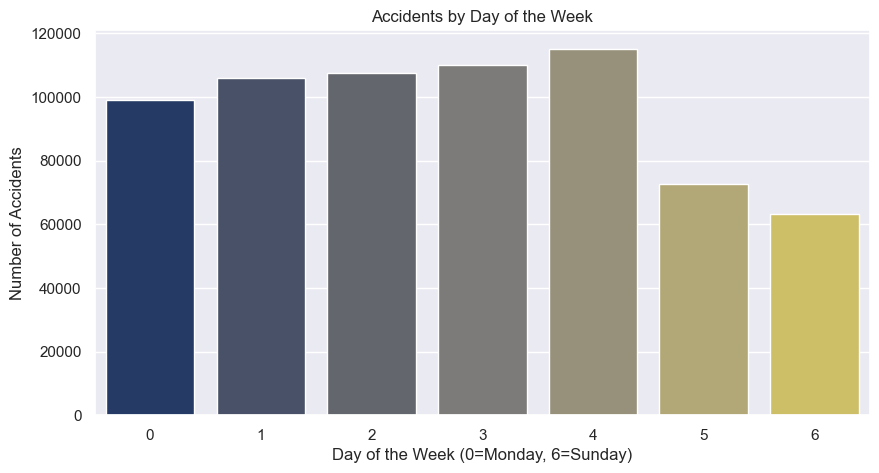

In [27]:
# Plot accidents by day of the week
plt.figure(figsize=(10, 5))
sns.countplot(x='Weekday', data=df, palette='cividis')
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

## 3.5) Accidents by Month

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/470108380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=df, palette='cool')


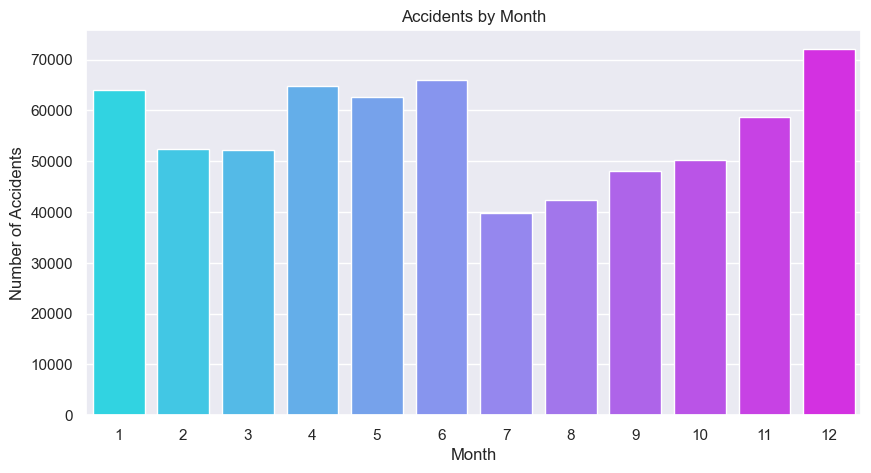

In [28]:
# Plot accidents by month
plt.figure(figsize=(10, 5))
sns.countplot(x='Month', data=df, palette='cool')
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.show()

## 3.6) Accidents vs. Temperature

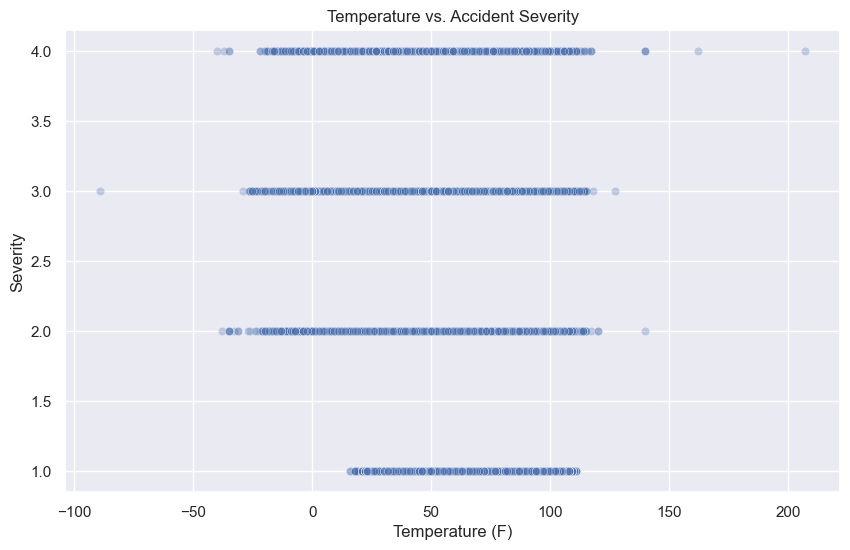

In [29]:
# Scatter plot of temperature vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature(F)', y='Severity', data=df, alpha=0.3)
plt.title("Temperature vs. Accident Severity")
plt.xlabel("Temperature (F)")
plt.ylabel("Severity")
plt.show()

## 3.7) Accidents vs. Visibility

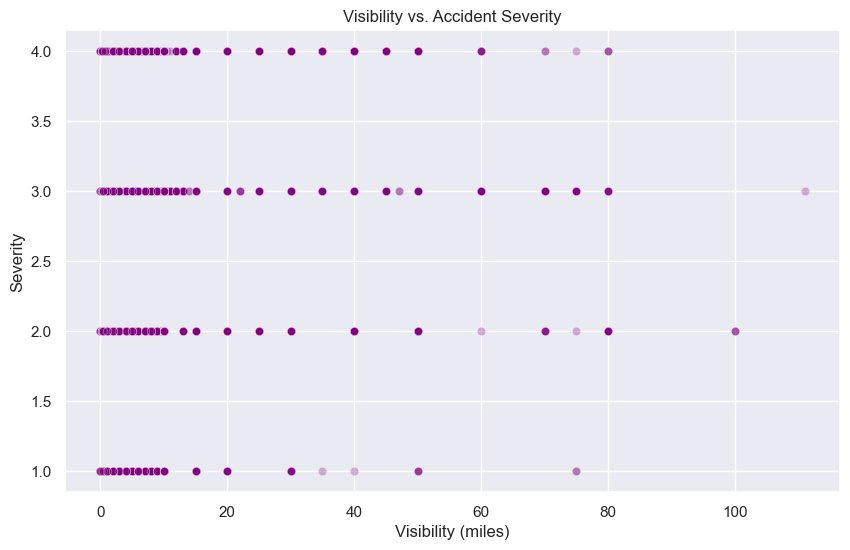

In [30]:
# Scatter plot of visibility vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Visibility(mi)', y='Severity', data=df, alpha=0.3, color='purple')
plt.title("Visibility vs. Accident Severity")
plt.xlabel("Visibility (miles)")
plt.ylabel("Severity")
plt.show()

In [31]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Street', 'City',
       'County', 'State', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud',
       'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog',
       'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke', 'Year', 'Month', 'Weekday',
       'Day', 'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')

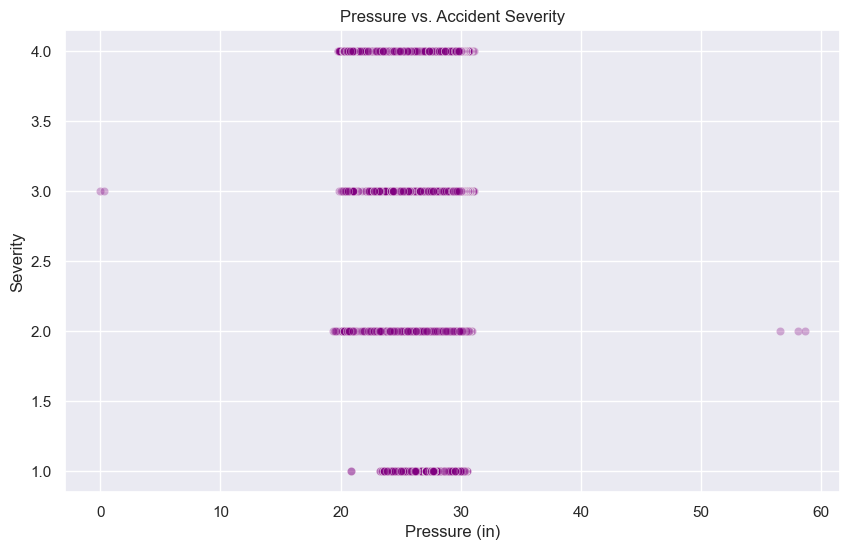

In [32]:
# Scatter plot of visibility vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pressure(in)', y='Severity', data=df, alpha=0.3, color='purple')
plt.title("Pressure vs. Accident Severity")
plt.xlabel("Pressure (in)")
plt.ylabel("Severity")
plt.show()

## 3.8) Accidents by State

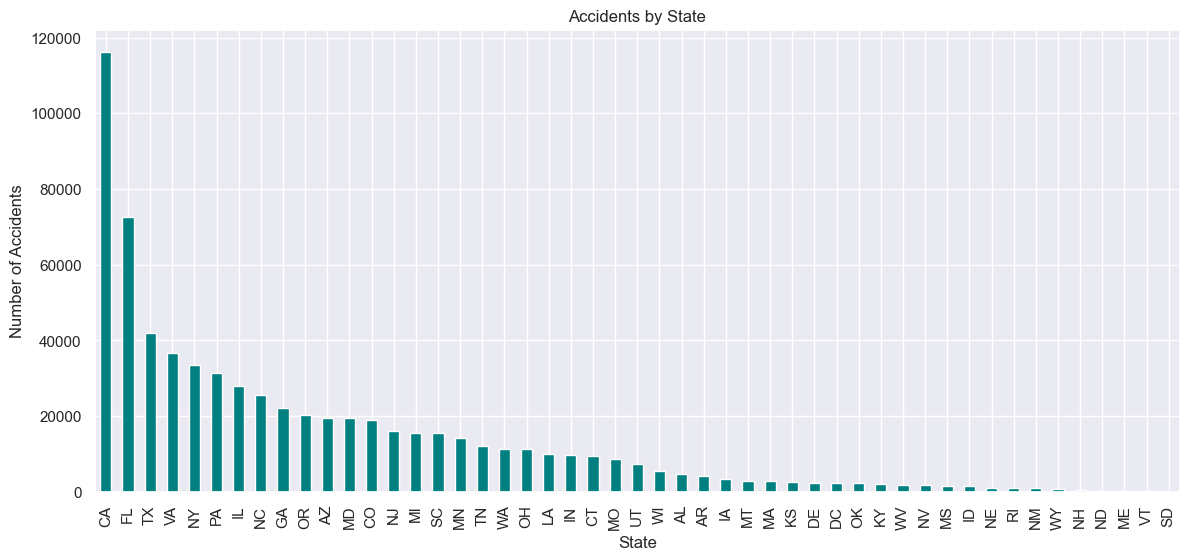

In [33]:
# Plot accident count by state
plt.figure(figsize=(14, 6))
df['State'].value_counts().plot(kind='bar', color='teal')
plt.title("Accidents by State")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.show()

## 3.9) Accidents by Humidity Levels

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_64961/2720265650.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Humidity(%)'], bins=30, kde=True, color='darkblue')


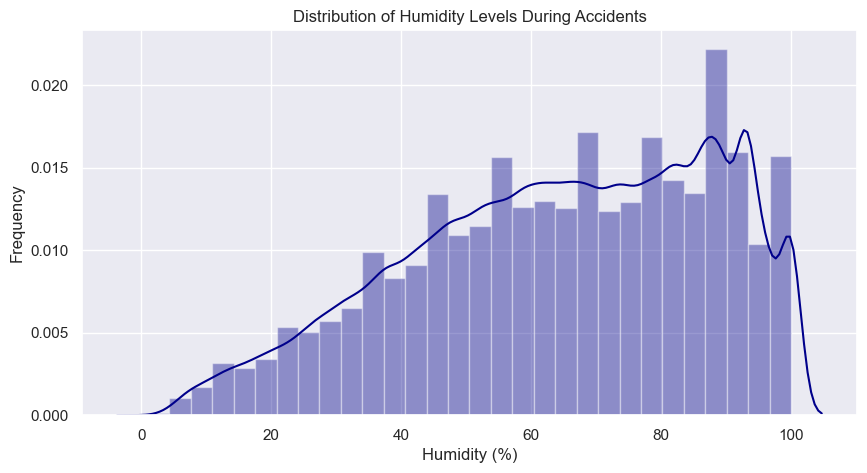

In [34]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Humidity(%)'], bins=30, kde=True, color='darkblue')
plt.title("Distribution of Humidity Levels During Accidents")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

## 3.10) Accidents by POI

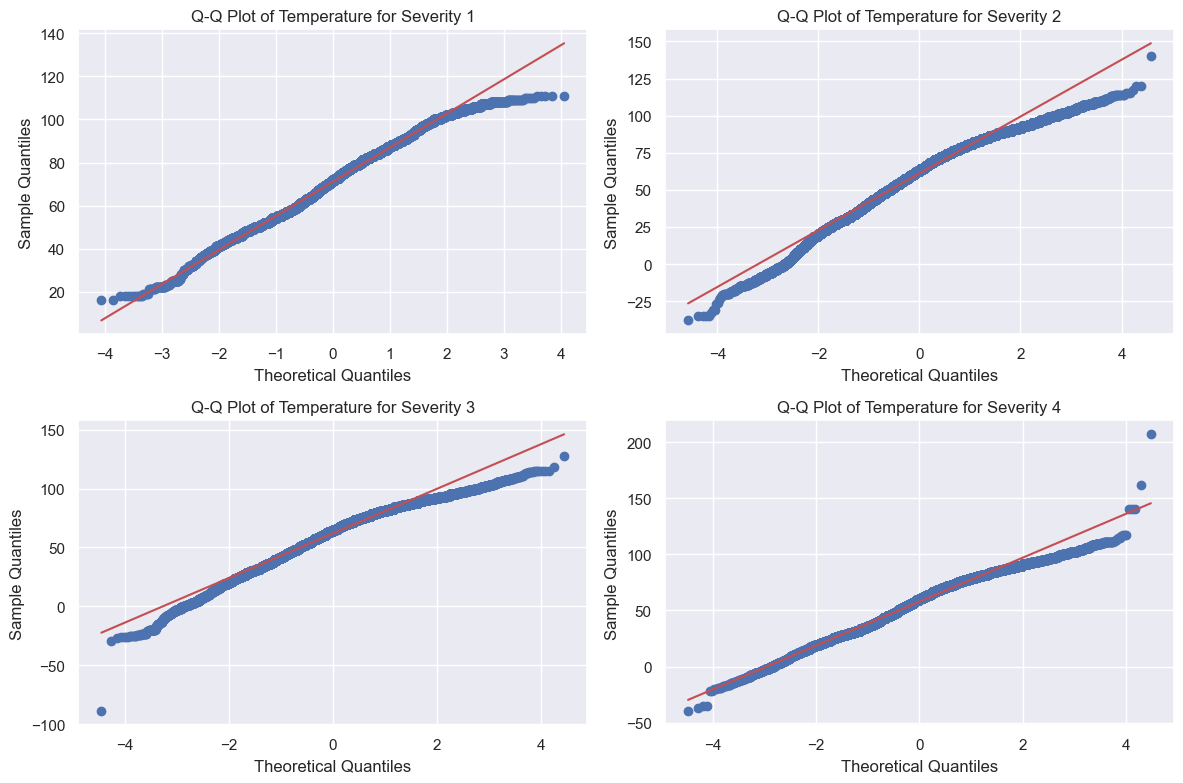

In [35]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set up the figure for subplots
severity_levels = df['Severity'].unique()
plt.figure(figsize=(12, 8))

# Generate a Q-Q plot for Temperature for each Severity level
for i, level in enumerate(severity_levels, 1):
    plt.subplot(2, 2, i)  # Adjust subplot grid if needed
    severity_temp = df[df['Severity'] == level]['Temperature(F)'].dropna()
    
    # Create the Q-Q plot
    stats.probplot(severity_temp, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Temperature for Severity {level}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


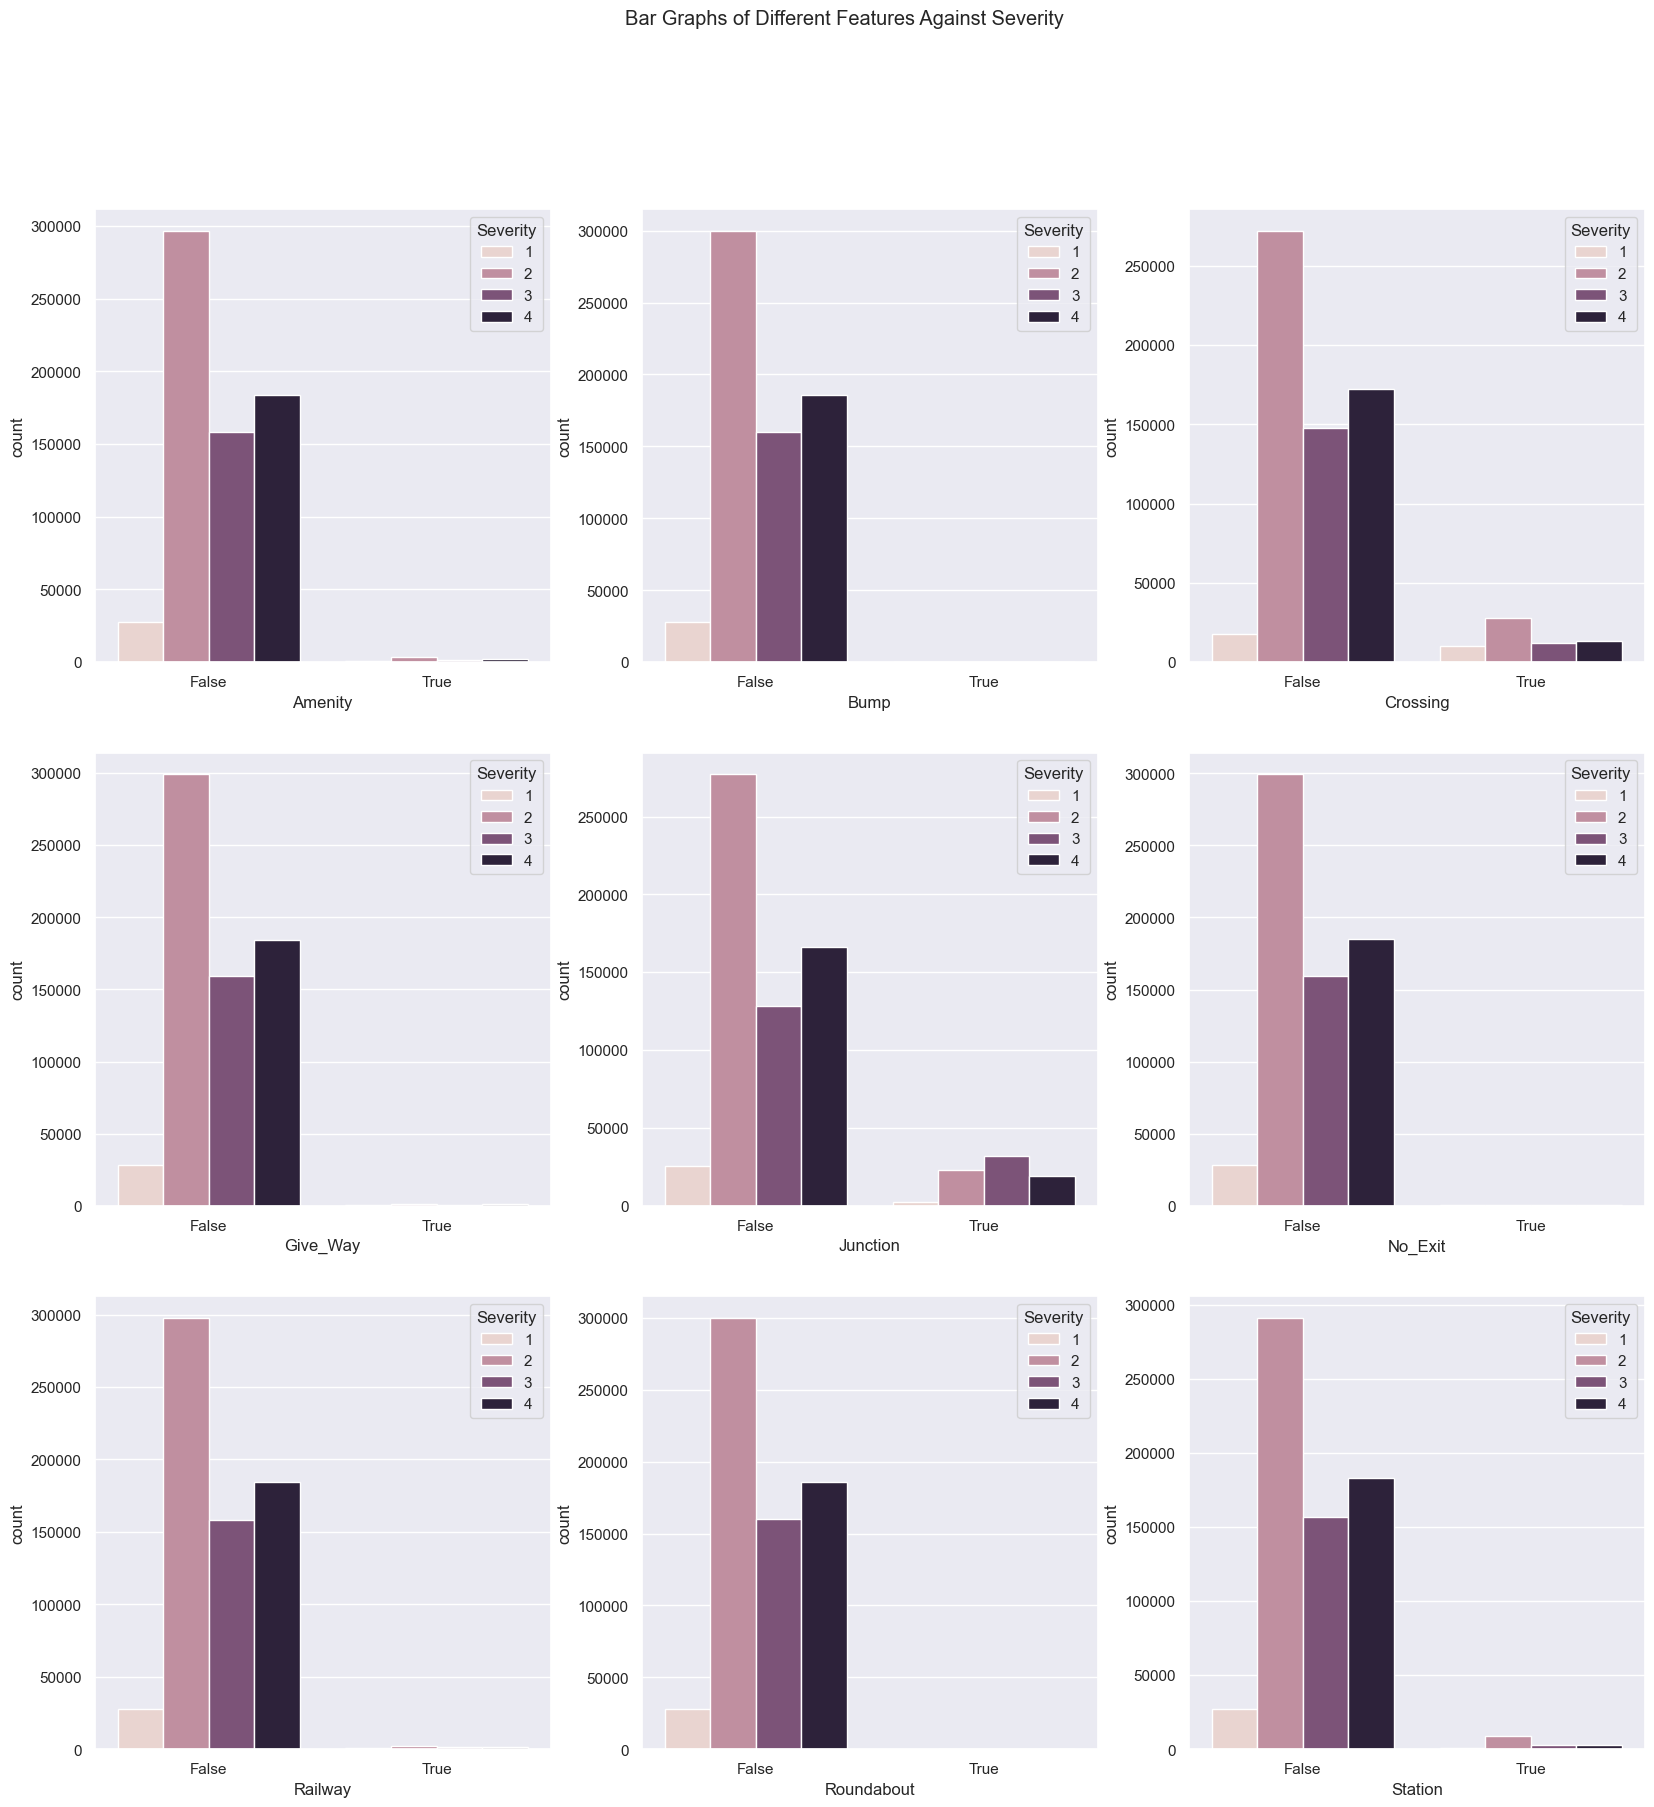

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Bar Graphs of Different Features Against Severity')

# Use df_balanced instead of df
sns.countplot(x='Amenity', hue='Severity', data=df, ax=axs[0, 0])
sns.countplot(x='Bump', hue='Severity', data=df, ax=axs[0, 1])
sns.countplot(x='Crossing', hue='Severity', data=df, ax=axs[0, 2])
sns.countplot(x='Give_Way', hue='Severity', data=df, ax=axs[1, 0])
sns.countplot(x='Junction', hue='Severity', data=df, ax=axs[1, 1])
sns.countplot(x='No_Exit', hue='Severity', data=df, ax=axs[1, 2])
sns.countplot(x='Railway', hue='Severity', data=df, ax=axs[2, 0])
sns.countplot(x='Roundabout', hue='Severity', data=df, ax=axs[2, 1])
sns.countplot(x='Station', hue='Severity', data=df, ax=axs[2, 2])

# Show the plots
plt.show()

# 4) Hypothesis Testing

## 4.1) Chi Square Test for Independence

Chi-Square Test for 'Severity' and 'Roundabout':
  Chi2 Statistic: 2.67, p-value: 0.44531784204395286
  Result: Null hypothesis accepted (no significant association)


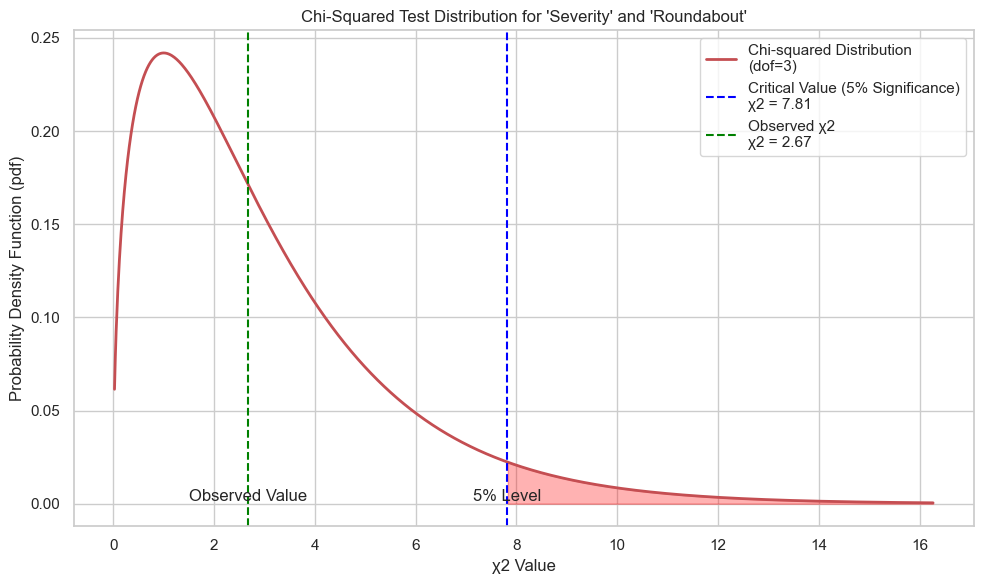

  Cells with expected frequency < 5: 3/8
--------------------------------------------------
Chi-Square Test for 'Severity' and 'Heavy_Rain':
  Chi2 Statistic: 311.34, p-value: 3.486379355585606e-67
  Result: Null hypothesis rejected (significant association)


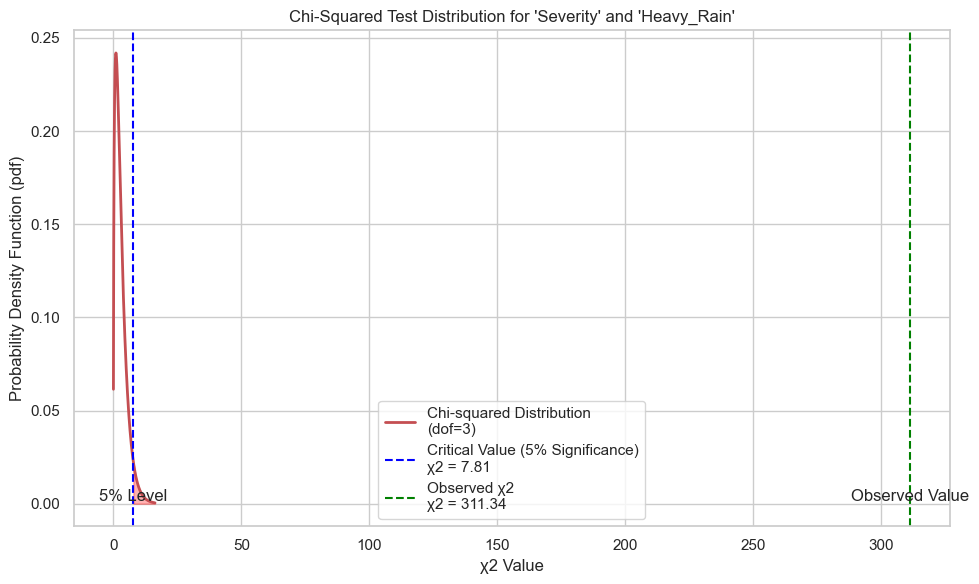

  Cells with expected frequency < 5: 0/8
--------------------------------------------------
Chi-Square Test for 'Severity' and 'Fog':
  Chi2 Statistic: 741.00, p-value: 2.6982929102789063e-160
  Result: Null hypothesis rejected (significant association)


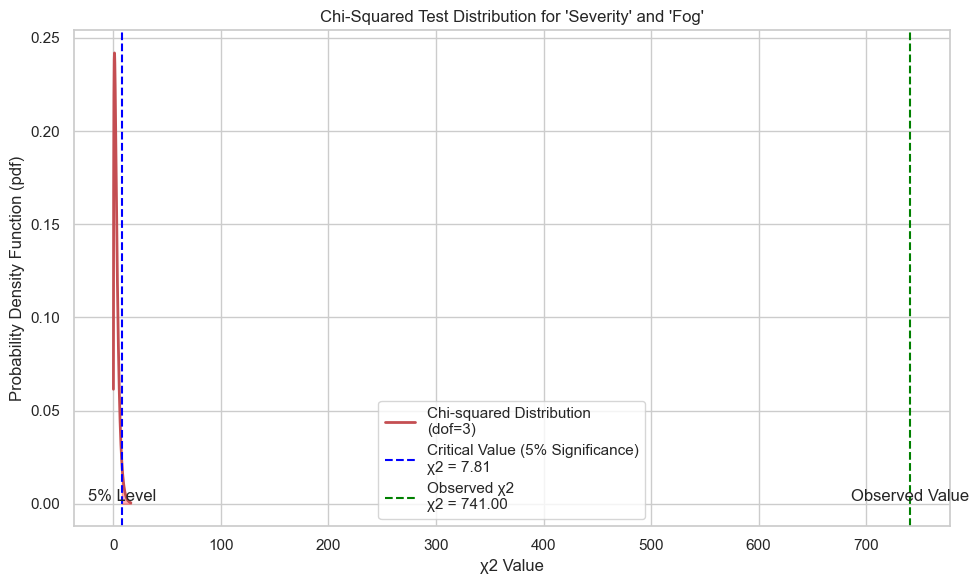

  Cells with expected frequency < 5: 0/8
--------------------------------------------------


In [37]:
from scipy.stats import chi2, chi2_contingency

# List of boolean columns to test against 'Severity'
boolean_columns = ['Roundabout', 'Heavy_Rain', 'Fog']

# Significance level
alpha = 0.05

# Loop over each boolean column, perform the Chi-square test, and print results
for column in boolean_columns:
    contingency_table = pd.crosstab(df['Severity'], df[column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test for 'Severity' and '{column}':")
    print(f"  Chi2 Statistic: {chi2_stat:.2f}, p-value: {p_value}")

    # Interpret the result based on the p-value and alpha
    if p_value < alpha:
        print("  Result: Null hypothesis rejected (significant association)")
    else:
        print("  Result: Null hypothesis accepted (no significant association)")
    
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Values for x-axis
    x = np.linspace(chi2.ppf(0.001, dof), chi2.ppf(0.999, dof), 1000)
    
    # Plot chi-squared distribution
    plt.plot(x, chi2.pdf(x, dof), 'r-', lw=2, label=f'Chi-squared Distribution\n(dof={dof})')
    
    # Highlight the region beyond the critical value for 5% significance
    critical_value = chi2.ppf(0.95, dof)
    plt.fill_between(x, chi2.pdf(x, dof), where=(x > critical_value), color="red", alpha=0.3)
    
    # Annotate the 5% critical value
    plt.axvline(critical_value, color='blue', linestyle='--', label=f'Critical Value (5% Significance)\nχ2 = {critical_value:.2f}')
    plt.text(critical_value, 0, '5% Level', horizontalalignment='center', verticalalignment='bottom')
    
    # Annotate the computed chi2 statistic
    plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed χ2\nχ2 = {chi2_stat:.2f}')
    plt.text(chi2_stat, 0, 'Observed Value', horizontalalignment='center', verticalalignment='bottom')
    
    # Add title and labels
    plt.title(f"Chi-Squared Test Distribution for 'Severity' and '{column}'")
    plt.xlabel("χ2 Value")
    plt.ylabel("Probability Density Function (pdf)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Validation Experiment - Expected Frequency Check
    count_low_freq = (expected < 5).sum()
    total_cells = expected.size
    print(f"  Cells with expected frequency < 5: {count_low_freq}/{total_cells}")
    print("-" * 50)

    # Bootstrapping for Consistency Check
    # print(f"Bootstrap Consistency Test for 'Severity' and '{column}'...")
    # n_iterations = 1000
    # p_values_bootstrap = []

    # for _ in range(n_iterations):
    #     bootstrap_sample = df.sample(frac=0.8, replace=True)
    #     bootstrap_contingency = pd.crosstab(bootstrap_sample['Severity'], bootstrap_sample[column])
    #     _, p_bootstrap, _, _ = chi2_contingency(bootstrap_contingency)
    #     p_values_bootstrap.append(p_bootstrap)

    # # Plot distribution of bootstrapped p-values
    # plt.hist(p_values_bootstrap, bins=30, color='skyblue', edgecolor='black')
    # plt.xlabel('P-value')
    # plt.ylabel('Frequency')
    # plt.title(f'Distribution of P-values from Bootstrapping for {column}')
    # plt.axvline(x=alpha, color='red', linestyle='--', label='Significance Level (alpha = 0.05)')
    # plt.legend()
    # plt.show()
    
    # print("\n")


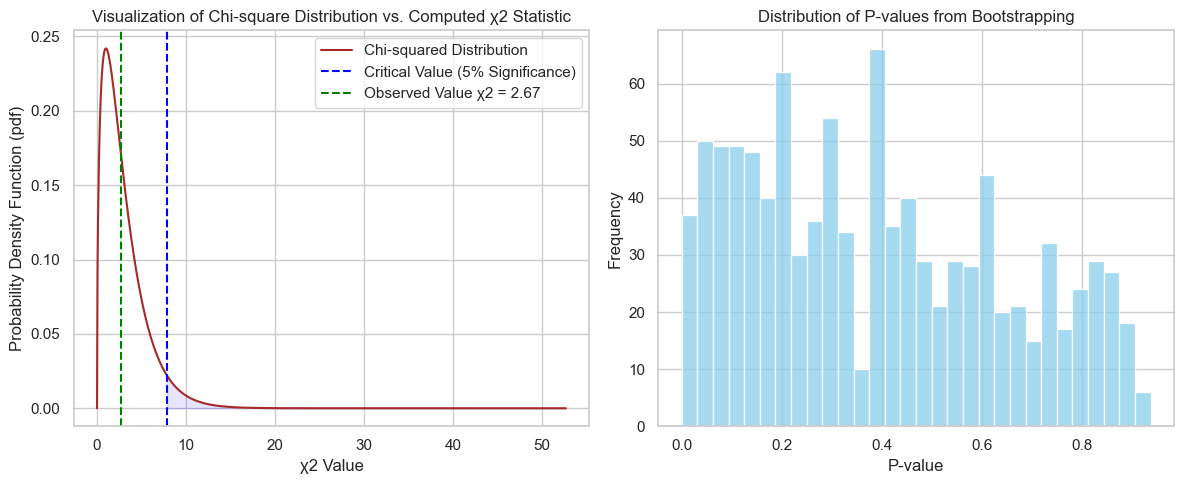

The original Chi-square test does not indicate a significant association (p-value = 0.44531784204395286).
Mean of Bootstrap P-values: 0.39024965980532217
95% Confidence Interval of P-values: (0.023260230158217782, 0.8728843929738905)
Bootstrap analysis does not confirm a significant association.


In [38]:
# Initialize variables
column_to_test = 'Roundabout'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

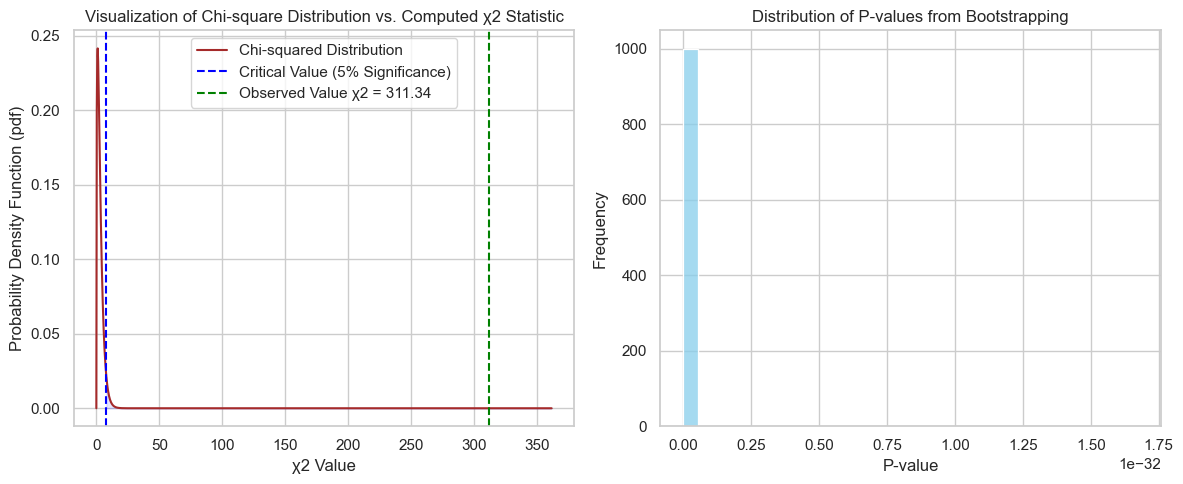

The original Chi-square test indicates a significant association (p-value = 3.486379355585606e-67).
Mean of Bootstrap P-values: 1.675783126507763e-35
95% Confidence Interval of P-values: (8.938497442774611e-70, 1.167341562375171e-41)
Bootstrap analysis confirms a significant association.


In [39]:
# Initialize variables
column_to_test = 'Heavy_Rain'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

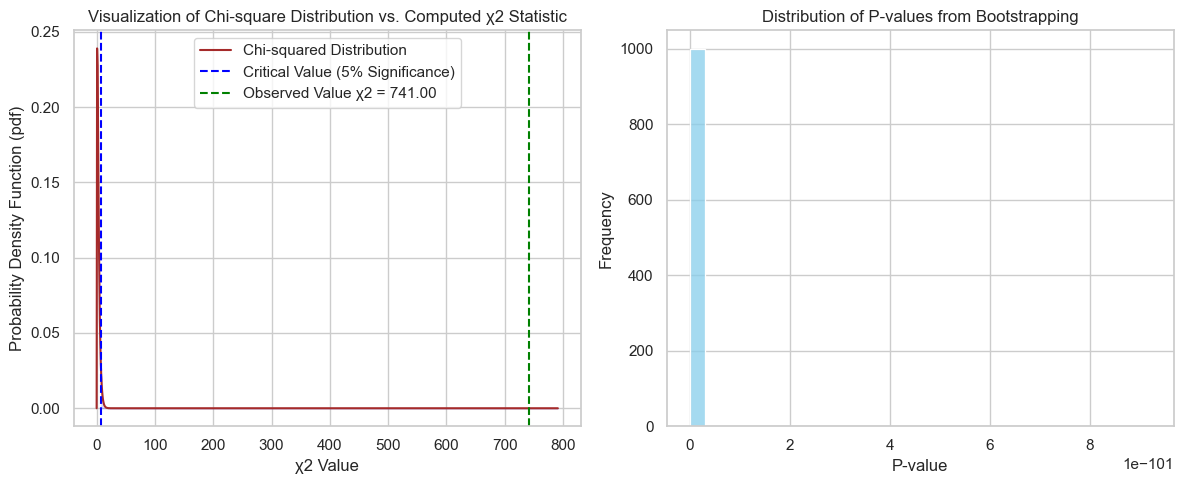

The original Chi-square test indicates a significant association (p-value = 2.6982929102789063e-160).
Mean of Bootstrap P-values: 9.905311263929136e-104
95% Confidence Interval of P-values: (9.980490063700277e-147, 4.856873223614991e-109)
Bootstrap analysis confirms a significant association.


In [40]:
# Initialize variables
column_to_test = 'Fog'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

## 4.2) Z test for two proportions

In [41]:
# Example: Count severe accidents in Heavy Snow vs non-Heavy Snow conditions
heavy_snow_accidents = df[df['Heavy_Snow'] == True]
non_heavy_snow_accidents = df[df['Heavy_Snow'] == False]

# Count the number of severe accidents (Severity = 4)
severe_heavy_snow = (heavy_snow_accidents['Severity'] == 4).sum()
total_heavy_snow = len(heavy_snow_accidents)

severe_non_heavy_snow = (non_heavy_snow_accidents['Severity'] == 4).sum()
total_non_heavy_snow = len(non_heavy_snow_accidents)


# Define null and alternative hypotheses
# H0: There is no significant difference in the proportion of severe accidents between Heavy Snow and non-Heavy Snow weather.
# H1: There is a significant difference in the proportion of severe accidents between Heavy Snow and non-Heavy Snow weather.

# Perform the Z-test for proportions
successes = np.array([severe_heavy_snow, severe_non_heavy_snow])
nobs = np.array([total_heavy_snow, total_non_heavy_snow])

z_stat, p_value = proportions_ztest(successes, nobs)

# Print Z-statistic and p-value
print(f"\nZ-statistic: {z_stat}")
print(f"P-value: {p_value}")

alpha = 0.05 
if p_value < alpha:
    print("\nReject the null hypothesis (H0). There is a significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.")
else:
    print("\nFail to reject the null hypothesis (H0). There is no significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.")


Z-statistic: 7.497390801767131
P-value: 6.510066792403325e-14

Reject the null hypothesis (H0). There is a significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.


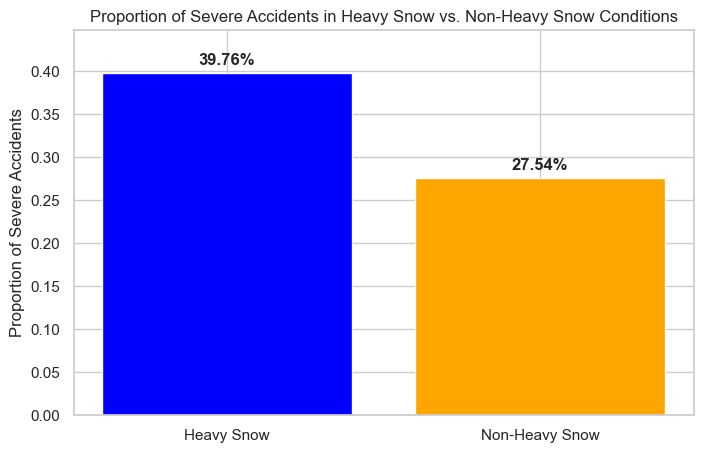

In [42]:
# Calculate proportions
prop_heavy_snow = severe_heavy_snow / total_heavy_snow if total_heavy_snow > 0 else 0
prop_non_heavy_snow = severe_non_heavy_snow / total_non_heavy_snow if total_non_heavy_snow > 0 else 0

# Bar plot
proportions = [prop_heavy_snow, prop_non_heavy_snow]
labels = ['Heavy Snow', 'Non-Heavy Snow']

plt.figure(figsize=(8, 5))
plt.bar(labels, proportions, color=['blue', 'orange'])
plt.ylim(0, max(proportions) + 0.05)  # Add some padding to the y-axis for better visualization
plt.ylabel('Proportion of Severe Accidents')
plt.title('Proportion of Severe Accidents in Heavy Snow vs. Non-Heavy Snow Conditions')

# Display proportions above bars
for i, prop in enumerate(proportions):
    plt.text(i, prop + 0.01, f"{prop:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.show()

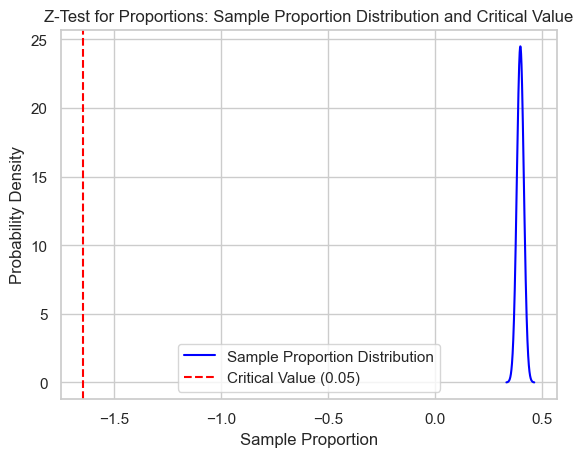

In [43]:
# Define sample and population values
sample_proportion = severe_heavy_snow / total_heavy_snow  # Sample proportion of severe accidents in heavy snow conditions
population_proportion = (severe_heavy_snow + severe_non_heavy_snow) / (total_heavy_snow + total_non_heavy_snow)  # Overall severe accident proportion

# Standard error calculation
sample_size = total_heavy_snow
se = np.sqrt((population_proportion * (1 - population_proportion)) / sample_size)

# Critical value for the significance level (alpha)
alpha = 0.05
critical_value = norm.ppf(alpha)  # Z-score critical value for left tail

# Create a range of values for the x-axis centered around the sample proportion
x = np.linspace(sample_proportion - 4 * se, sample_proportion + 4 * se, 1000)

# Plot the normal distribution of the sample proportion
plt.plot(x, norm.pdf(x, sample_proportion, se), label='Sample Proportion Distribution', color='blue')

# Draw a vertical line at the critical value
plt.axvline(critical_value, color='red', linestyle='--', label=f'Critical Value ({alpha})')

# Shade the area to the left of the critical value for the rejection region
# plt.fill_between(x, 0, norm.pdf(x, sample_proportion, se), where=(x <= critical_value), color='red', alpha=0.2, label='Rejection Region')

# Add labels, legend, and title
plt.xlabel('Sample Proportion')
plt.ylabel('Probability Density')
plt.title('Z-Test for Proportions: Sample Proportion Distribution and Critical Value')
plt.legend()

# Show the plot
plt.show()

## 4.3) T test for correlation

In [44]:
columns_to_analyze = [('Humidity(%)', 'Temperature(F)')]

alpha = 0.05

def correlation_test(column1, column2):
    # Calculate the correlation coefficient and p-value
    r, _ = stats.pearsonr(df[column1], df[column2])
    
    # Calculate sample size
    n = len(df)
    
    # Calculate the t-statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    
    # Calculate the p-value for the two-tailed test
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2))
    
    return r, t_stat, p_value

# Iterate through the pairs of columns
results = []
for col1, col2 in columns_to_analyze:
    r, t_stat, p_value = correlation_test(col1, col2)
    results.append((col1, col2, r, t_stat, p_value))
    # Print the results
    print(f"Columns: {col1} and {col2}")
    print(f"  Correlation Coefficient (r): {r}")
    print(f"  T-statistic: {t_stat}")

    # Decision based on p-value
    if p_value < alpha:
        print("  Reject the null hypothesis (H0): There is a significant correlation.")
    else:
        print("  Fail to reject the null hypothesis (H0): There is no significant correlation.")
    print()  

Columns: Humidity(%) and Temperature(F)
  Correlation Coefficient (r): -0.34860029635785794
  T-statistic: -305.2669781959981
  Reject the null hypothesis (H0): There is a significant correlation.



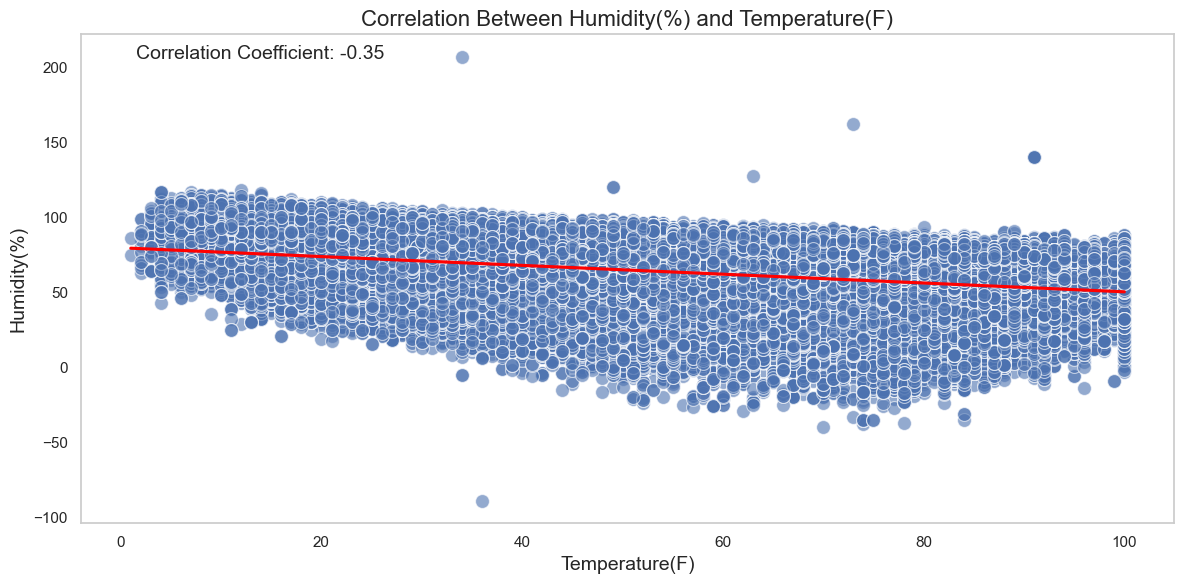

In [45]:
col1 = 'Humidity(%)'
col2 = 'Temperature(F)'

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(data=df, x=col1, y=col2, alpha=0.6, edgecolor='w', s=100)

sns.regplot(data=df, x=col1, y=col2, scatter=False, color='red', ci=None)

correlation_coefficient = df[col1].corr(df[col2])

plt.annotate(f'Correlation Coefficient: {correlation_coefficient:.2f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction', 
             fontsize=14, 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title(f'Correlation Between {col1} and {col2}', fontsize=16)
plt.ylabel(col1, fontsize=14)
plt.xlabel(col2, fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

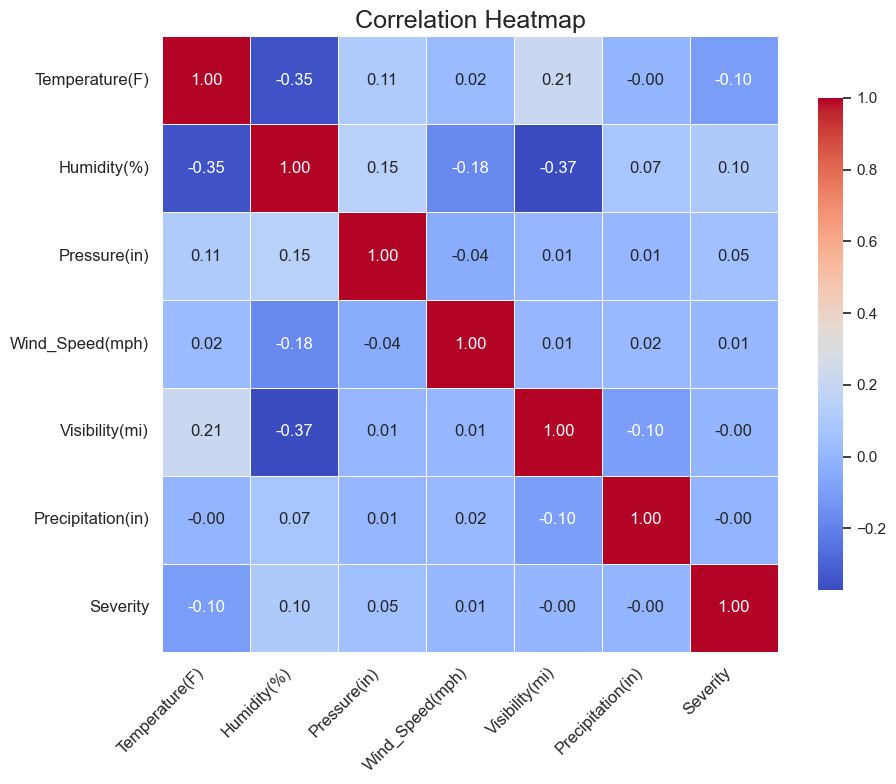

In [46]:
# Define continuous columns to analyze for correlation
continuous_columns = [
    'Temperature(F)', 
    'Humidity(%)', 
    'Pressure(in)', 
    'Wind_Speed(mph)', 
    'Visibility(mi)', 
    'Precipitation(in)', 
    'Severity'
]

# Calculate the correlation matrix
correlation_matrix = df[continuous_columns].corr()

# Set the style for the heatmap
sns.set(style='whitegrid')

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, 
                       annot=True, 
                       fmt=".2f", 
                       cmap='coolwarm', 
                       square=True, 
                       cbar_kws={"shrink": .8}, 
                       linewidths=.5)

# Customize the heatmap
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Show the heatmap
plt.show()

## 4.4) Z test for 1 population proportions

In [47]:
from statsmodels.stats.proportion import proportions_ztest

severe_accidents = df[df['Severity'].isin([3, 4])]

night_accidents = severe_accidents[severe_accidents['Sunrise_Sunset'] == 'Night'].shape[0]

total_severe_accidents = severe_accidents.shape[0]

# Calculate observed proportion
p_hat = night_accidents / total_severe_accidents
p_0 = 0.6  # Hypothesized population proportion for nighttime severe accidents

# Perform the Z-test for proportion
count = night_accidents
nobs = total_severe_accidents
z_stat, p_value = proportions_ztest(count, nobs, value=p_0, alternative='larger')

# Output results
print("Z-Statistic:", z_stat)
print("P-Value:", p_value)

# Conclusion based on significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Proportion of nighttime severe accidents is significantly greater than 0.6")
else:
    print("Fail to reject the null hypothesis: Proportion of nighttime severe accidents is not significantly greater than 0.6")


Z-Statistic: -288.1130152115506
P-Value: 1.0
Fail to reject the null hypothesis: Proportion of nighttime severe accidents is not significantly greater than 0.6


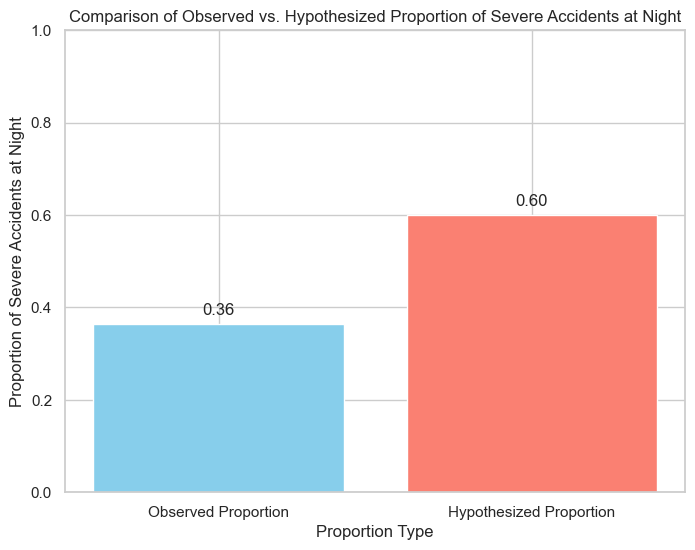

In [48]:
# Observed proportion of severe accidents at night
observed_proportion = night_accidents / total_severe_accidents
hypothesized_proportion = 0.6  # Hypothesized threshold for proportion of nighttime severe accidents

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Observed Proportion', 'Hypothesized Proportion'], 
        [observed_proportion, hypothesized_proportion], 
        color=['skyblue', 'salmon'])

# Add labels and title for clarity
plt.xlabel('Proportion Type')
plt.ylabel('Proportion of Severe Accidents at Night')
plt.title('Comparison of Observed vs. Hypothesized Proportion of Severe Accidents at Night')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for proportion range

# Annotate the bars with the actual proportion values
plt.text(0, observed_proportion + 0.02, f'{observed_proportion:.2f}', ha='center')
plt.text(1, hypothesized_proportion + 0.02, f'{hypothesized_proportion:.2f}', ha='center')

# Display the plot
plt.show()

## 4.5) T test for 2 population mean

In [49]:
from scipy.stats import ttest_ind

# Separate data into mild (Severity 1) and serious (Severity 4) accidents
mild_accidents = df[df['Severity'].isin([1])]
serious_accidents = df[df['Severity'].isin([4])]

# Extract 'Visibility(mi)' values for each group
mild_visibility = mild_accidents['Visibility(mi)'].dropna()
serious_visibility = serious_accidents['Visibility(mi)'].dropna()

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(mild_visibility, serious_visibility, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in visibility between mild and serious accidents.")
else:
    print("There is no significant difference in visibility between mild and serious accidents.")

T-statistic: 33.38720339477357
P-value: 1.281253898122376e-241
There is a significant difference in visibility between mild and serious accidents.


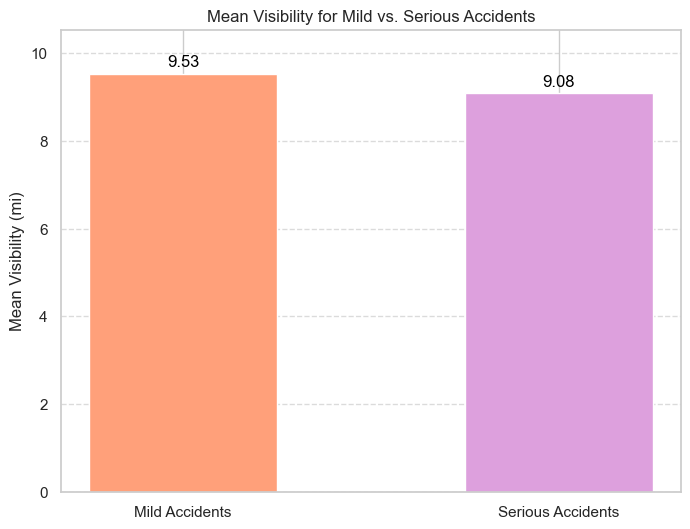

In [50]:
mean_mild_visibility = mild_visibility.mean()
mean_serious_visibility = serious_visibility.mean()

# Bar plot with mean value labels
plt.figure(figsize=(8, 6))
bars = plt.bar(['Mild Accidents', 'Serious Accidents'], 
               [mean_mild_visibility, mean_serious_visibility], 
               color=['#FFA07A', '#DDA0DD'],  
               width=0.5)  # Adjust bar width

# Adding labels
plt.ylabel('Mean Visibility (mi)')
plt.title('Mean Visibility for Mild vs. Serious Accidents')

# Adding grid for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust y-axis limits to provide space above bars
plt.ylim(0, max(mean_mild_visibility, mean_serious_visibility) + 1)

# Label the bars with their mean values
for bar, mean in zip(bars, [mean_mild_visibility, mean_serious_visibility]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, 
             f'{mean:.2f}', ha='center', va='bottom', color='black', fontsize=12)

plt.show()

# 5) Dimensionality Reduction

## Preprocessing Data

In [21]:
# create a deep copy of the original dataframe
df_copy = df.copy()
df.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Street,City,County,State,Airport_Code,Temperature(F),...,Hail,Tornado,Smoke,Year,Month,Weekday,Day,Hour,Minute,Precipitation_NA
6525681,1,2020-08-03 14:35:16,32.20676,-110.98050,W Starr Pass Blvd,Tucson,Pima,AZ,KDMA,103.0,...,False,False,False,2020,8,0,3,14,35,0
6527285,1,2020-09-22 16:44:38,32.38084,-110.96392,E Linda Vista Blvd,Tucson,Pima,AZ,KDMA,95.0,...,False,False,False,2020,9,1,22,16,44,0
6540036,1,2020-08-03 15:42:10,41.37978,-81.99410,I-80 W,North Ridgeville,Lorain,OH,KCLE,68.0,...,False,False,False,2020,8,0,3,15,42,0
6542183,1,2020-09-22 16:29:33,33.63950,-112.13436,W Bell Rd,Phoenix,Maricopa,AZ,KDVT,98.0,...,False,False,False,2020,9,1,22,16,29,0
6543739,1,2020-08-03 13:41:01,38.08320,-122.11450,I-680 S,Benicia,Solano,CA,KCCR,95.0,...,False,False,False,2020,8,0,3,13,41,0


In [22]:
# print the column names and their data types
df_copy.nunique()

# search for all the categorical columns
categorical_columns = df_copy.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['Street', 'City', 'County', 'State', 'Airport_Code', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')


In [23]:
# restore the original dataframe
# df = df_copy.copy()

# remove Street City County Airport_Code column
df = df.drop(['Start_Time', 'County', 'Street', 'City', 'Airport_Code'], axis=1)


In [24]:
# search for all the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['State', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [25]:
import pandas as pd

# Step 1: Identify non-numerical columns (dtype == object)
non_numerical_columns = df.select_dtypes(include=['object']).columns

# Step 2: Perform one-hot encoding on the non-numerical columns
df_encoded = pd.get_dummies(df, columns=non_numerical_columns, drop_first=True)

# Display the updated DataFrame
print("Columns after one-hot encoding:")
print(df_encoded.columns)

# print dimensions of the dataframe
print(df_encoded.shape)


Columns after one-hot encoding:
Index(['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Clear', 'Cloud', 'Light_Rain',
       'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog', 'Dust',
       'Wind', 'Hail', 'Tornado', 'Smoke', 'Year', 'Month', 'Weekday', 'Day',
       'Hour', 'Minute', 'Precipitation_NA', 'State_AR', 'State_AZ',
       'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL',
       'State_GA', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS',
       'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI',
       'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND',
       'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'Stat

In [26]:
# # convert to numpy array
# d_encoded_processed = df_encoded.to_numpy()
# # print number of dimensions
# print(d_encoded_processed.ndim)
print(df_encoded.shape)

(673653, 93)


In [57]:
# categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # Preprocessing for numerical and categorical data
# numerical_transformer = SimpleImputer(strategy='mean')
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessors in a column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )

## Model Results Dictionary

In [27]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import time

# model names
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'K-Nearest Neighbors','XGBoost', 'MLP']
reduction_methods = ['Original', 'SVD', 'PCA', 'JL', 'Matrix_Completion', 'Feature_Selection']

# create a dictionary to store the accuracy and time taken for each model across different datasets
models_results = {}

# initialize the dictionary with the model names as keys, the values are dictionaries with keys of different datasets and values of accuracy and time taken
for model_name in model_names:
    models_results[model_name] = {}
    for reduction_method in reduction_methods:
        models_results[model_name][reduction_method] = {'accuracy': 0, 'time': 0}



## Original Data

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

X = df_encoded.drop(columns=['Severity'])  # Replace 'Severity' with the actual target column
y = df_encoded['Severity']
y = y - 1  # Adjust if necessary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



### Original Data Results

In [29]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import time
from xgboost import XGBClassifier

# Define models
models = {    
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    # 'MLP': create_mlp(X_train.shape[1], len(y.unique()))
    # 'SVM': SVC(kernel='linear', probability=True, random_state=42),
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    start_time = time.time()

    # Train other models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    end_time = time.time()

    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    # print classification report
    # print(classification_report(y_test, y_pred))
    print("-" * 50)

    # Store results in the dictionary according to model name and reduction method
    models_results[model_name]['Original']['accuracy'] = accuracy
    models_results[model_name]['Original']['time'] = end_time - start_time




Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.6726
Time taken: 41.98 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.5206
Time taken: 0.56 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.8131
Time taken: 76.86 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.6893
Time taken: 70.05 seconds
--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.7505
Time taken: 4.70 seconds
--------------------------------------------------


In [30]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Convert target to categorical for MLP
y_train_categorical = to_categorical(y_train)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test)

# Train and evaluate the MLP
mlp_model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(5, activation='relu'),
    Dense(len(y.unique()), activation='softmax')
])
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Training and evaluating MLP...")

start_time = time.time()

# Train the MLP model
mlp_model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, verbose=1)
_, accuracy = mlp_model.evaluate(X_test, y_test_categorical, verbose=0)

end_time = time.time()

print(f"Accuracy for MLP: {accuracy:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print("-" * 50)

# Store results in the dictionary according to model name and reduction method
models_results['MLP']["Original"]['accuracy'] = accuracy
models_results['MLP']["Original"]['time'] = end_time - start_time



Training and evaluating MLP...
Epoch 1/5


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14737/14737 ━━━━━━━━━━━━━━━━━━━━ 7s 418us/step - accuracy: 0.6493 - loss: 0.7739
Epoch 2/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 386us/step - accuracy: 0.7134 - loss: 0.6232
Epoch 3/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 415us/step - accuracy: 0.7173 - loss: 0.6071
Epoch 4/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 428us/step - accuracy: 0.7207 - loss: 0.6021
Epoch 5/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 387us/step - accuracy: 0.7209 - loss: 0.5998
Accuracy for MLP: 0.7200
Time taken: 32.61 seconds
--------------------------------------------------


### Accuracy Plot

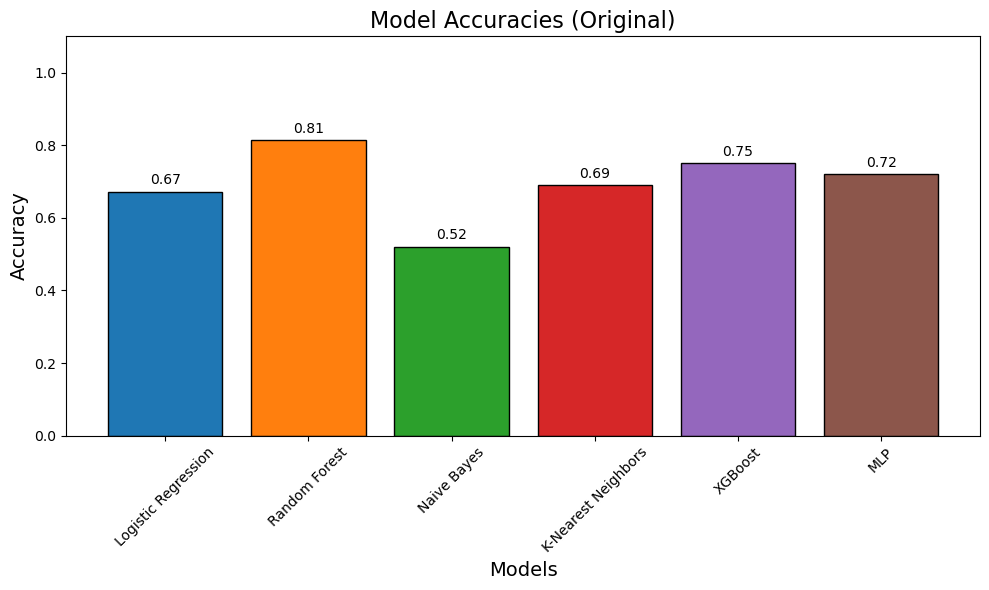

In [31]:
import matplotlib.pyplot as plt

# Extract accuracy and time for the 'Original' key
model_names = list(models_results.keys())
original_accuracies = [models_results[model]['Original']['accuracy'] for model in model_names]
original_times = [models_results[model]['Original']['time'] for model in model_names]

# Define unique colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot Accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, original_accuracies, color=colors, edgecolor='black')
plt.title('Model Accuracies (Original)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # Set y-limit to 1.1 for better visualization
plt.xticks(rotation=45)

# Annotate accuracy values
for bar, acc in zip(bars, original_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{acc:.2f}', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Time Taken Plot

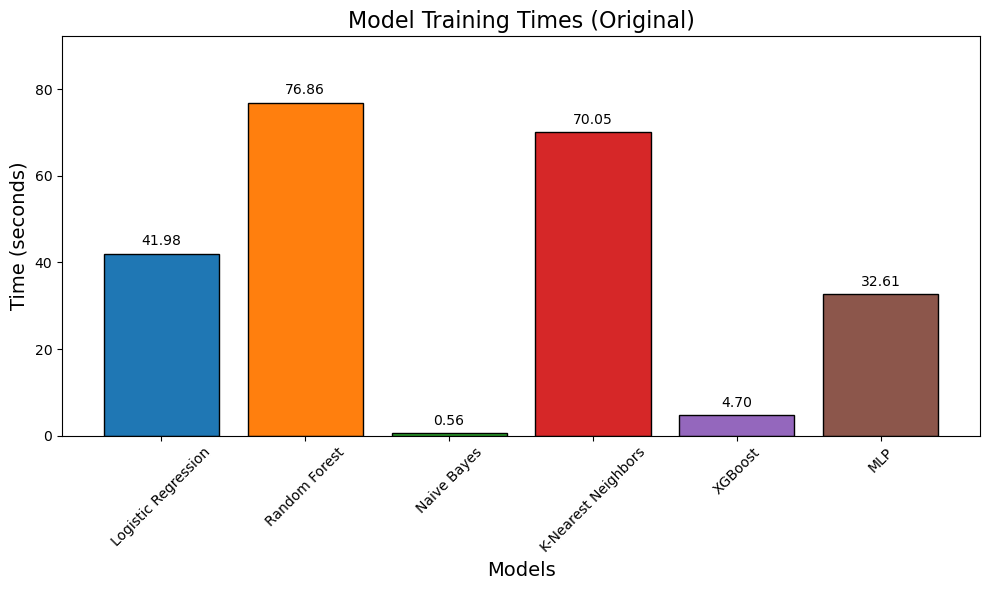

In [32]:
# Plot Times
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, original_times, color=colors, edgecolor='black')
plt.title('Model Training Times (Original)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
plt.ylim(0, max(original_times) * 1.2)  # Add some buffer to the upper limit
plt.xticks(rotation=45)

# Annotate time values
for bar, times in zip(bars, original_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{times:.2f}', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Functions

In [44]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import time

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
}


# models_results['Logistic Regression']['Original']['accuracy'] = 0.5
# print(models_results)

# Define the MLP model
def create_mlp(input_dim_, num_classes_):
    model_ = Sequential([
        Dense(10, activation='relu', input_shape=(input_dim_,)),
        Dense(5, activation='relu'),
        Dense(num_classes_, activation='softmax')
    ])
    model_.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_

# Function to train and evaluate a model
def train_and_evaluate_model(model_name_, model_, X_train_, y_train_, X_test_, y_test_, reduction_method_, is_mlp_=False):
    
    print(f"Training and evaluating {model_name_}...")
    start_time_ = time.time()
    if is_mlp_:
        # Train MLP
        model_.fit(X_train_, y_train_, epochs=5, batch_size=32, verbose=1)
        _, accuracy_ = model_.evaluate(X_test_, y_test_, verbose=0)
    else:
        # Train other models
        model_.fit(X_train_, y_train_)
        y_pred_ = model_.predict(X_test_)
        accuracy_ = accuracy_score(y_test_, y_pred_)

    end_time_ = time.time()

    print(f"Accuracy for {model_name_}: {accuracy_:.4f}")
    print(f"Time taken: {end_time_ - start_time_:.2f} seconds")
    # print classification report
    # print(classification_report(y_test, y_pred))
    print("-" * 50)

    # Store results in the dictionary according to model name and reduction method
    models_results[model_name_][reduction_method_]['accuracy'] = accuracy_
    models_results[model_name_][reduction_method_]['time'] = end_time_ - start_time_



## SVD

In [45]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd
from sklearn.model_selection import train_test_split

# Redeclare X and y
X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']
y = y - 1  # Adjust if necessary

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

k = 10  # Set the desired number of dimensions
U, S, Vt = svd(X_scaled, full_matrices=False)

# Keep only the top k components
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]

X_approx = np.dot(U_k, np.dot(S_k, Vt_k))
X_red = np.dot(X_scaled, Vt_k.T)
X_reduced = pd.DataFrame(X_red, columns=[f"Component_{i+1}" for i in range(k)])
print(X_reduced.head())


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)


   Component_1  Component_2  Component_3  Component_4  Component_5  \
0    -3.053575    -2.140404    -1.059410     0.487726    -4.244729   
1    -3.092805    -3.236779    -1.698853     0.116409    -3.722605   
2    -0.810049     2.564588     1.057974    -2.184647     1.237027   
3    -3.003385    -3.388034    -1.433914     0.223237    -3.465239   
4    -2.154314    -2.169866    -1.693977     0.509334     1.487562   

   Component_6  Component_7  Component_8  Component_9  Component_10  
0    -1.229929     1.069199    -0.048486    -0.080642      2.118928  
1    -0.982035     0.264112     0.730807     1.627046      1.787344  
2    -1.544712     0.007706     0.432219     2.618687      2.904965  
3    -1.131457    -0.280807     0.951977     1.283100      1.854984  
4    -0.401138    -0.666509     0.377610     0.192501     -0.733100  


### SVD Results

In [46]:
# models

In [47]:
# Convert target to categorical for MLP
y_train_categorical = to_categorical(y_train)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test)

# Iterate through traditional models
for model_name, model in models.items():
    train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, 'SVD')

# Train and evaluate the MLP
mlp_model = create_mlp(input_dim_=X_train.shape[1], num_classes_=y_train_categorical.shape[1])
train_and_evaluate_model('MLP', mlp_model, X_train, y_train_categorical, X_test, y_test_categorical, 'SVD', is_mlp_=True)

# Print final results for only 'SVD' dataset
print("Final Results for SVD Dataset:")
for model_name, results in models_results.items():
    # format the output
    print(f"{model_name}:")
    print(f"  Accuracy: {results['SVD']['accuracy']:.4f}")
    print(f"  Time taken: {results['SVD']['time']:.2f} seconds")
    print("-" * 50)
    

Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.6065
Time taken: 1.00 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.5796
Time taken: 0.09 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.7247
Time taken: 19.49 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.6848
Time taken: 15.43 seconds
--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.6541
Time taken: 2.68 seconds
--------------------------------------------------
Training and evaluating MLP...
Epoch 1/5


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14737/14737 ━━━━━━━━━━━━━━━━━━━━ 7s 433us/step - accuracy: 0.6000 - loss: 0.8891
Epoch 2/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 396us/step - accuracy: 0.6339 - loss: 0.8062
Epoch 3/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 386us/step - accuracy: 0.6354 - loss: 0.7980
Epoch 4/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 381us/step - accuracy: 0.6360 - loss: 0.7916
Epoch 5/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 415us/step - accuracy: 0.6363 - loss: 0.7894
Accuracy for MLP: 0.6354
Time taken: 32.07 seconds
--------------------------------------------------
Final Results for SVD Dataset:
Logistic Regression:
  Accuracy: 0.6065
  Time taken: 1.00 seconds
--------------------------------------------------
Random Forest:
  Accuracy: 0.7247
  Time taken: 19.49 seconds
--------------------------------------------------
Naive Bayes:
  Accuracy: 0.5796
  Time taken: 0.09 seconds
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.6848
  Time taken: 15.43 seconds
-------------

In [65]:
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# import time
# from sklearn.preprocessing import StandardScaler

# # Define models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
#     'Naive Bayes': GaussianNB(),
#     'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
#     'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
#     # 'SVM': SVC(kernel='linear', probability=True, random_state=42),
#     # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# }


# for model_name, model in models.items():
#     print(f"Training and evaluating {model_name}...")

#     # start time
#     start_time = time.time()

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # end time
#     end_time = time.time()

#     total_accuracy = accuracy_score(y_test, y_pred)

#     # avg_accuracy = total_accuracy / num_epochs
#     print(f"Accuracy for {model_name}: {total_accuracy:.4f}")
    
#     # print classification report
#     print("Classification Report for", model_name)
#     print(classification_report(y_test, y_pred))

#     print(f"Time taken to train and evaluate {model_name}: {end_time - start_time:.2f} seconds")
#     print("-" * 50)
#     print()

#     # store the results in the model_results dictionary
#     models_results[model_name]['SVD']['accuracy'] = total_accuracy
#     models_results[model_name]['SVD']['time'] = end_time - start_time
    

## PCA

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Redeclare X and y
X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']
y = y - 1  # Adjust if necessary

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA (you can choose the number of components, here k=20)
k=40
pca = PCA(n_components=k)  
X_pca = pca.fit_transform(X_scaled)

# Step 3: Check the explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance with 10 components: {explained_variance:.2f}")

# Step 4: Convert reduced data back to a DataFrame (optional)
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(k)])

# Step 5: Print or save the reduced data (optional)
print(X_pca_df.head())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.3, random_state=42)


Explained Variance with 10 components: 0.57
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.060275 -2.166898 -1.041740 -0.594250  4.117161  1.072899 -0.807801   
1  3.093962 -3.261740 -1.712048 -0.191497  3.687061  0.969896 -0.383842   
2  0.818340  2.504539  1.047995  2.062975 -1.300600  1.432531 -0.121045   
3  3.004607 -3.410053 -1.447047 -0.301841  3.434875  1.123277  0.175691   
4  2.154729 -2.170189 -1.688587 -0.499290 -1.501642  0.386057  0.708060   

        PC8       PC9      PC10  ...      PC31      PC32      PC33      PC34  \
0  0.177632  0.011100 -2.549647  ...  1.734717 -0.793268 -0.239000 -1.192836   
1 -0.803974  1.464073 -1.579850  ...  0.158137 -0.365250 -0.022779  0.019026   
2 -0.432412  2.020046 -2.853272  ...  1.387313 -0.843101  0.426968 -1.363627   
3 -1.017481  1.103129 -1.668777  ...  0.326492 -0.289573 -0.117906 -0.142134   
4 -0.378650  0.235705  0.755130  ... -0.118475 -0.404036 -0.100291 -0.244425   

       PC35      PC36   

### PCA Results

In [49]:
# Convert target to categorical for MLP
y_train_categorical = to_categorical(y_train)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test)

# Iterate through traditional models
for model_name, model in models.items():
    train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, 'PCA')

# Train and evaluate the MLP
mlp_model = create_mlp(input_dim_=X_train.shape[1], num_classes_=y_train_categorical.shape[1])
train_and_evaluate_model('MLP', mlp_model, X_train, y_train_categorical, X_test, y_test_categorical, 'PCA', is_mlp_=True)

# Print final results for only 'PCA' dataset
print("Final Results for PCA Dataset:")
for model_name, results in models_results.items():
    # format the output
    print(f"{model_name}:")
    print(f"  Accuracy: {results['PCA']['accuracy']:.4f}")
    print(f"  Time taken: {results['PCA']['time']:.2f} seconds")
    print("-" * 50)

Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.6409
Time taken: 7.54 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.5134
Time taken: 0.26 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.7333
Time taken: 41.32 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.6877
Time taken: 46.77 seconds
--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.6811
Time taken: 4.47 seconds
--------------------------------------------------
Training and evaluating MLP...
Epoch 1/5


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14737/14737 ━━━━━━━━━━━━━━━━━━━━ 7s 430us/step - accuracy: 0.6198 - loss: 0.8482
Epoch 2/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 426us/step - accuracy: 0.6737 - loss: 0.7211
Epoch 3/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 430us/step - accuracy: 0.6783 - loss: 0.7077
Epoch 4/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 419us/step - accuracy: 0.6817 - loss: 0.7008
Epoch 5/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 410us/step - accuracy: 0.6855 - loss: 0.6919
Accuracy for MLP: 0.6868
Time taken: 33.91 seconds
--------------------------------------------------
Final Results for PCA Dataset:
Logistic Regression:
  Accuracy: 0.6409
  Time taken: 7.54 seconds
--------------------------------------------------
Random Forest:
  Accuracy: 0.7333
  Time taken: 41.32 seconds
--------------------------------------------------
Naive Bayes:
  Accuracy: 0.5134
  Time taken: 0.26 seconds
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.6877
  Time taken: 46.77 seconds
-------------

In [68]:
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# import time
# from sklearn.preprocessing import StandardScaler


# # Define models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
#     'Naive Bayes': GaussianNB(),
#     'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
#     'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
#     # 'SVM': SVC(kernel='linear', probability=True, random_state=42),
#     # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# }

# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)


# for model_name, model in models.items():
#     print(f"Training and evaluating {model_name}...")

#     # start time
#     start_time = time.time()

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # end time
#     end_time = time.time()

#     total_accuracy = accuracy_score(y_test, y_pred)

#     # avg_accuracy = total_accuracy / num_epochs
#     print(f"Accuracy for {model_name}: {total_accuracy:.4f}")
    
#     # print classification report
#     print("Classification Report for", model_name)
#     print(classification_report(y_test, y_pred))


#     print(f"Time taken to train and evaluate {model_name}: {end_time - start_time:.2f} seconds")
#     print("-" * 50)
#     print()

#     # store the results in the model_results dictionary
#     models_results[model_name]['PCA']['accuracy'] = total_accuracy
#     models_results[model_name]['PCA']['time'] = end_time - start_time
    

## Random Projection (JL)

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

k = 40  # Set the desired number of dimensions

# Redeclare X and y
X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']
y = y - 1  # Adjust if necessary

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_features = X_scaled.shape[1]
JL_matrix = np.random.choice([1/np.sqrt(k), -1/np.sqrt(k)], size=(n_features, k))
X_reduced = np.dot(X_scaled, JL_matrix)
X_reduced_df = pd.DataFrame(X_reduced, columns=[f"Component_{i+1}" for i in range(k)])
print(X_reduced_df.head())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced_df, y, test_size=0.3, random_state=42)

   Component_1  Component_2  Component_3  Component_4  Component_5  \
0     4.439517    -0.599843     3.020492     0.855593    -0.984297   
1     0.778534     1.504818     0.101549    -1.107087     0.761990   
2     2.026001    -1.321706    -0.539366    -0.670334     2.329261   
3     0.915594     1.924323     0.013254    -1.018791     0.593450   
4     1.123082    -0.088624    -0.001121     0.566945     0.433436   

   Component_6  Component_7  Component_8  Component_9  Component_10  ...  \
0     2.013686     3.508622     4.051703    -0.141928     -0.600004  ...   
1    -0.743933     0.640810    -0.114690     1.830689     -1.926951  ...   
2    -0.650882    -1.158696     2.627853    -3.086107     -0.943605  ...   
3    -0.346216     0.418565    -0.336935     1.978489     -2.018410  ...   
4     0.037097    -0.811199    -0.657087    -0.264309     -1.182670  ...   

   Component_31  Component_32  Component_33  Component_34  Component_35  \
0     -3.083967      4.683486     -3.304461    

### Random Projection (JL) Results

In [51]:
# Convert target to categorical for MLP
y_train_categorical = to_categorical(y_train)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test)

# Iterate through traditional models
for model_name, model in models.items():
    train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, 'JL')

# Train and evaluate the MLP
mlp_model = create_mlp(input_dim_=X_train.shape[1], num_classes_=y_train_categorical.shape[1])
train_and_evaluate_model('MLP', mlp_model, X_train, y_train_categorical, X_test, y_test_categorical, 'JL', is_mlp_=True)

# Print final results for only 'JL' dataset
print("Final Results for JL Dataset:")
for model_name, results in models_results.items():
    # format the output
    print(f"{model_name}:")
    print(f"  Accuracy: {results['JL']['accuracy']:.4f}")
    print(f"  Time taken: {results['JL']['time']:.2f} seconds")
    print("-" * 50)


Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.6162
Time taken: 5.49 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.5231
Time taken: 0.23 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.7151
Time taken: 37.12 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.6854
Time taken: 49.04 seconds
--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.6715
Time taken: 4.80 seconds
--------------------------------------------------
Training and evaluating MLP...
Epoch 1/5


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 394us/step - accuracy: 0.5926 - loss: 0.9008
Epoch 2/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 380us/step - accuracy: 0.6653 - loss: 0.7386
Epoch 3/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 393us/step - accuracy: 0.6702 - loss: 0.7242
Epoch 4/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 403us/step - accuracy: 0.6751 - loss: 0.7144
Epoch 5/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 407us/step - accuracy: 0.6749 - loss: 0.7099
Accuracy for MLP: 0.6777
Time taken: 31.61 seconds
--------------------------------------------------
Final Results for JL Dataset:
Logistic Regression:
  Accuracy: 0.6162
  Time taken: 5.49 seconds
--------------------------------------------------
Random Forest:
  Accuracy: 0.7151
  Time taken: 37.12 seconds
--------------------------------------------------
Naive Bayes:
  Accuracy: 0.5231
  Time taken: 0.23 seconds
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.6854
  Time taken: 49.04 seconds
--------------

In [71]:
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# import time
# from sklearn.preprocessing import StandardScaler

# # Define models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
#     'Naive Bayes': GaussianNB(),
#     'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
#     'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
#     # 'SVM': SVC(kernel='linear', probability=True, random_state=42),
#     # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# }

# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)


# for model_name, model in models.items():
#     print(f"Training and evaluating {model_name}...")

#     # start time
#     start_time = time.time()

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # end time
#     end_time = time.time()

#     total_accuracy = accuracy_score(y_test, y_pred)

#     # avg_accuracy = total_accuracy / num_epochs
#     print(f"Accuracy for {model_name}: {total_accuracy:.4f}")
    
#     # print classification report
#     print("Classification Report for", model_name)
#     print(classification_report(y_test, y_pred))


#     print(f"Time taken to train and evaluate {model_name}: {end_time - start_time:.2f} seconds")
#     print("-" * 50)
#     print()

#     # store the results in the model_results dictionary
#     models_results[model_name]['JL']['accuracy'] = total_accuracy
#     models_results[model_name]['JL']['time'] = end_time - start_time

## Matrix Completion

In [32]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Step 1: Identify missing values and prepare the matrix for completion
df_copy = df_with_missing_data.copy()

df_copy = df_copy.drop(['Start_Time', 'County', 'Street', 'City', 'Airport_Code'], axis=1)
non_numerical_columns = df_copy.select_dtypes(include=['object']).columns

# Step 2: Perform one-hot encoding on the non-numerical columns
df_encoded = pd.get_dummies(df_copy, columns=non_numerical_columns, drop_first=True)

# We'll apply matrix completion only to numerical columns (features with missing values)
numerical_features = df_encoded.select_dtypes(include=[np.number]).columns
X_matrix = df_encoded[numerical_features]

# Step 2: Fill NaNs temporarily with column-wise mean (or median) to allow SVD to work
X_matrix_filled = X_matrix.copy()

# Fill NaN values with column mean
X_matrix_filled = X_matrix_filled.apply(lambda col: col.fillna(col.mean()), axis=0)

# Step 3: Matrix Completion using SVD
def matrix_completion(X, rank=10, max_iter=200, tol=1e-5):
    """
    Perform matrix completion using SVD by iterating over the missing values.
    """
    X_completed = X.copy()
    
    # Iterate through the matrix completion process
    for iteration in range(max_iter):
        # Apply SVD
        svd = TruncatedSVD(n_components=rank)
        # print(X_completed.shape)
        X_approx = svd.fit_transform(X_completed)
        # print(X_approx.shape)

        # Reconstruct the matrix to the original shape (4325632, 15)
        X_approx = np.dot(X_approx, svd.components_)
        # print(X_approx.shape)

        # Replace missing values with approximated values
        mask = np.isnan(X)
        X_completed = np.where(mask, X_approx, X)

        # Check for convergence
        error = np.linalg.norm(X_completed - X_approx, 'fro') / np.linalg.norm(X_approx, 'fro')
        if error < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return X_completed

# Step 4: Perform matrix completion on the dataset
X_completed = matrix_completion(X_matrix_filled, rank=10)

# Step 5: Replace the original matrix with the completed matrix
df_encoded[numerical_features] = X_completed

# Step 6: Merge the non-numerical features (those without missing values) back to the DataFrame
df_final = df_encoded.copy()



In [33]:
# save the final dataframe to a csv file
df_final.to_csv('matrixcompleted_df_final_200iterations.csv', index=False)

In [36]:
from sklearn.model_selection import train_test_split

Weather_data = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
df_final = df_final.dropna(subset=Weather_data)

df_final = pd.concat([df_final[df_final['Severity'] == 1], df_final[df_final['Severity'] == 2].sample(n=300000, random_state=42), df_final[df_final['Severity'] == 3], df_final[df_final['Severity'] == 4]])

# Step 7: Prepare the data for model training (after handling missing values)
# Handle categorical columns or apply further preprocessing if necessary
df_final['Severity'] = df_final['Severity'].astype('category')

# Split the data into features (X) and target (y)
X_final = df_final.drop(columns='Severity')
y_final = df_final['Severity']

# You can now use `X_final` and `y_final` for model training
print("Data preparation is complete.")

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

Data preparation is complete.


### Matrix Completion Results

In [40]:
from tensorflow.keras.utils import to_categorical
# Ensure y_train and y_test are numeric types
y_train_numeric = y_train.cat.codes  # Convert categorical to numeric codes
y_test_numeric = y_test.cat.codes

# Convert target to categorical for MLP (adjusting classes to start from 0)
y_train_categorical = to_categorical(y_train_numeric - 1)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test_numeric - 1)

# Iterate through traditional models
for model_name, model in models.items():
    train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, 'Matrix_Completion')

# Train and evaluate the MLP
mlp_model = create_mlp(input_dim=X_train.shape[1], num_classes=y_train_categorical.shape[1])
train_and_evaluate_model('MLP', mlp_model, X_train, y_train_categorical, X_test, y_test_categorical, 'Matrix_Completion', is_mlp=True)

# Print final results for only 'SVD' dataset
print("Final Results for Matrix Completion Dataset:")
for model_name, results in models_results.items():
    # format the output
    print(f"{model_name}:")
    print(f"  Accuracy: {results['Matrix_Completion']['accuracy']:.4f}")
    print(f"  Time taken: {results['Matrix_Completion']['time']:.2f} seconds")
    print("-" * 50)


Training and evaluating Logistic Regression...


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression: 0.4949
Time taken: 138.48 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.4790
Time taken: 0.69 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.7602
Time taken: 7.76 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.5744
Time taken: 68.01 seconds
--------------------------------------------------


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training and evaluating MLP...
Epoch 1/5
14876/14876 ━━━━━━━━━━━━━━━━━━━━ 7s 423us/step - accuracy: 0.4279 - loss: 3.8961
Epoch 2/5
14876/14876 ━━━━━━━━━━━━━━━━━━━━ 6s 390us/step - accuracy: 0.4411 - loss: 1.0675
Epoch 3/5
14876/14876 ━━━━━━━━━━━━━━━━━━━━ 6s 381us/step - accuracy: 0.4424 - loss: 1.0669
Epoch 4/5
14876/14876 ━━━━━━━━━━━━━━━━━━━━ 6s 395us/step - accuracy: 0.4411 - loss: 1.0677
Epoch 5/5
14876/14876 ━━━━━━━━━━━━━━━━━━━━ 6s 386us/step - accuracy: 0.4426 - loss: 1.0670
Accuracy for MLP: 0.4404
Time taken: 32.32 seconds
--------------------------------------------------
Final Results for Matrix Completion Dataset:
Logistic Regression:
  Accuracy: 0.4949
  Time taken: 138.48 seconds
--------------------------------------------------
Random Forest:
  Accuracy: 0.7602
  Time taken: 7.76 seconds
--------------------------------------------------
Naive Bayes:
  Accuracy: 0.4790
  Time taken: 0.69 seconds
--------------------------------------------------
K-Nearest Neighbors:
  Ac

## Feature Selection

In [52]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

non_numerical_columns = df.select_dtypes(include=['object']).columns

# Step 2: Perform one-hot encoding on the non-numerical columns
df_encoded = pd.get_dummies(df, columns=non_numerical_columns, drop_first=True)

# Step 1: Prepare the dataset
X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']
y = y - 1  # Adjust if necessary

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply Lasso Regression for Feature Selection
lasso = Lasso(alpha=0.1)  # Regularization strength (higher alpha shrinks more features to zero)
lasso.fit(X_scaled, y)

# Identify the features selected by Lasso (non-zero coefficients)
selected_features = np.where(lasso.coef_ != 0)[0]

# Step 4: Reduce the dataset to the selected features
X_selected = X.iloc[:, selected_features]

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)



### Feature Selection Results

In [53]:
# Convert target to categorical for MLP (as before)
y_train_categorical = to_categorical(y_train)  # Adjusting classes to start from 0
y_test_categorical = to_categorical(y_test)

# Step 6: Iterate through traditional models using the selected features
for model_name, model in models.items():
    train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, 'Feature_Selection')

# Train and evaluate the MLP model using selected features
mlp_model = create_mlp(input_dim_=X_train.shape[1], num_classes_=y_train_categorical.shape[1])
train_and_evaluate_model('MLP', mlp_model, X_train, y_train_categorical, X_test, y_test_categorical, 'Feature_Selection', is_mlp_=True)

# Step 7: Print final results for 'Feature Selection (Lasso)' dataset
print("Final Results for Feature Selection (Lasso) Dataset:")
for model_name, results in models_results.items():
    # format the output
    print(f"{model_name}:")
    print(f"  Accuracy: {results['Feature_Selection']['accuracy']:.4f}")
    print(f"  Time taken: {results['Feature_Selection']['time']:.2f} seconds")
    print("-" * 50)

Training and evaluating Logistic Regression...


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression: 0.5762
Time taken: 33.14 seconds
--------------------------------------------------
Training and evaluating Naive Bayes...
Accuracy for Naive Bayes: 0.5858
Time taken: 0.06 seconds
--------------------------------------------------
Training and evaluating Random Forest...
Accuracy for Random Forest: 0.7661
Time taken: 7.26 seconds
--------------------------------------------------
Training and evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.7538
Time taken: 3.89 seconds
--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.7209
Time taken: 2.14 seconds
--------------------------------------------------
Training and evaluating MLP...
Epoch 1/5


/Users/jyotir/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14737/14737 ━━━━━━━━━━━━━━━━━━━━ 7s 444us/step - accuracy: 0.4418 - loss: 2.5926
Epoch 2/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 404us/step - accuracy: 0.4448 - loss: 1.1907
Epoch 3/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 397us/step - accuracy: 0.4455 - loss: 1.1909
Epoch 4/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 404us/step - accuracy: 0.4463 - loss: 1.1900
Epoch 5/5
14737/14737 ━━━━━━━━━━━━━━━━━━━━ 6s 408us/step - accuracy: 0.4466 - loss: 1.1900
Accuracy for MLP: 0.4445
Time taken: 32.88 seconds
--------------------------------------------------
Final Results for Feature Selection (Lasso) Dataset:
Logistic Regression:
  Accuracy: 0.5762
  Time taken: 33.14 seconds
--------------------------------------------------
Random Forest:
  Accuracy: 0.7661
  Time taken: 7.26 seconds
--------------------------------------------------
Naive Bayes:
  Accuracy: 0.5858
  Time taken: 0.06 seconds
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.7538
  Time taken: 3.89 

## Comparison

In [62]:
# models_results

In [64]:
# print the results for all the models in a nice format
for model_name, results in models_results.items():
    print(f"{model_name}:")
    for reduction_method, values in results.items():
        print(f"  {reduction_method}:")
        print(f"    Accuracy: {values['accuracy']:.4f}")
        print(f"    Time taken: {values['time']:.2f} seconds")
    print("-" * 50)
    print()

Logistic Regression:
  Original:
    Accuracy: 0.6726
    Time taken: 41.98 seconds
  SVD:
    Accuracy: 0.6065
    Time taken: 1.00 seconds
  PCA:
    Accuracy: 0.6409
    Time taken: 7.54 seconds
  JL:
    Accuracy: 0.6162
    Time taken: 5.49 seconds
  Feature_Selection:
    Accuracy: 0.5762
    Time taken: 33.14 seconds
--------------------------------------------------

Random Forest:
  Original:
    Accuracy: 0.8131
    Time taken: 76.86 seconds
  SVD:
    Accuracy: 0.7247
    Time taken: 19.49 seconds
  PCA:
    Accuracy: 0.7333
    Time taken: 41.32 seconds
  JL:
    Accuracy: 0.7151
    Time taken: 37.12 seconds
  Feature_Selection:
    Accuracy: 0.7661
    Time taken: 7.26 seconds
--------------------------------------------------

Naive Bayes:
  Original:
    Accuracy: 0.5206
    Time taken: 0.56 seconds
  SVD:
    Accuracy: 0.5796
    Time taken: 0.09 seconds
  PCA:
    Accuracy: 0.5134
    Time taken: 0.26 seconds
  JL:
    Accuracy: 0.5231
    Time taken: 0.23 seconds
  F

In [63]:
# # create a deep copy of models_results
# models_results_copy = models_results.copy()

In [ ]:
# drop the entries in models_results dictionary for 'Matrix_Completion' for each model
for model_name in model_names:
    models_results[model_name].pop('Matrix_Completion')

In [59]:
# print the models_results dictionary with the accuracy and time taken for each model across different reduction methods in a tabular format
models_results_df = pd.DataFrame(models_results)
models_results_df

,Logistic Regression,Random Forest,Naive Bayes,K-Nearest Neighbors,XGBoost,MLP
Original,"{'accuracy': 0.6725813474784261, 'time': 41.97...","{'accuracy': 0.8130987253582456, 'time': 76.86...","{'accuracy': 0.520589224922809, 'time': 0.5578...","{'accuracy': 0.689315968648563, 'time': 70.054...","{'accuracy': 0.7505442957802233, 'time': 4.699...","{'accuracy': 0.7199994325637817, 'time': 32.60..."
SVD,"{'accuracy': 0.6064988916158657, 'time': 1.000...","{'accuracy': 0.7247446757976407, 'time': 19.49...","{'accuracy': 0.5795760430686406, 'time': 0.094...","{'accuracy': 0.6848477951072758, 'time': 15.43...","{'accuracy': 0.6540752909508353, 'time': 2.682...","{'accuracy': 0.6354356408119202, 'time': 32.06..."
PCA,"{'accuracy': 0.6408637479217798, 'time': 7.535...","{'accuracy': 0.733300015834059, 'time': 41.316...","{'accuracy': 0.5134490539149711, 'time': 0.261...","{'accuracy': 0.687663288734067, 'time': 46.766...","{'accuracy': 0.6810624653629958, 'time': 4.467...","{'accuracy': 0.6868270635604858, 'time': 33.90..."
JL,"{'accuracy': 0.6161675639300135, 'time': 5.493...","{'accuracy': 0.7150562109096666, 'time': 37.12...","{'accuracy': 0.5230929855118359, 'time': 0.232...","{'accuracy': 0.6854019871744121, 'time': 49.03...","{'accuracy': 0.671487807774523, 'time': 4.7993...","{'accuracy': 0.6776779294013977, 'time': 31.61..."
Feature_Selection,"{'accuracy': 0.5762409943789091, 'time': 33.13...","{'accuracy': 0.7660963106642388, 'time': 7.256...","{'accuracy': 0.585825548254295, 'time': 0.0631...","{'accuracy': 0.7538249148919326, 'time': 3.891...","{'accuracy': 0.7208900720449687, 'time': 2.143...","{'accuracy': 0.4445115327835083, 'time': 32.87..."


/var/folders/jh/_t8scx1x6w94mv1mjlpmy5xr0000gn/T/ipykernel_94109/372225841.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  accuracy_data = models_results_df.applymap(lambda x: x['accuracy'])


<Figure size 1200x600 with 0 Axes>

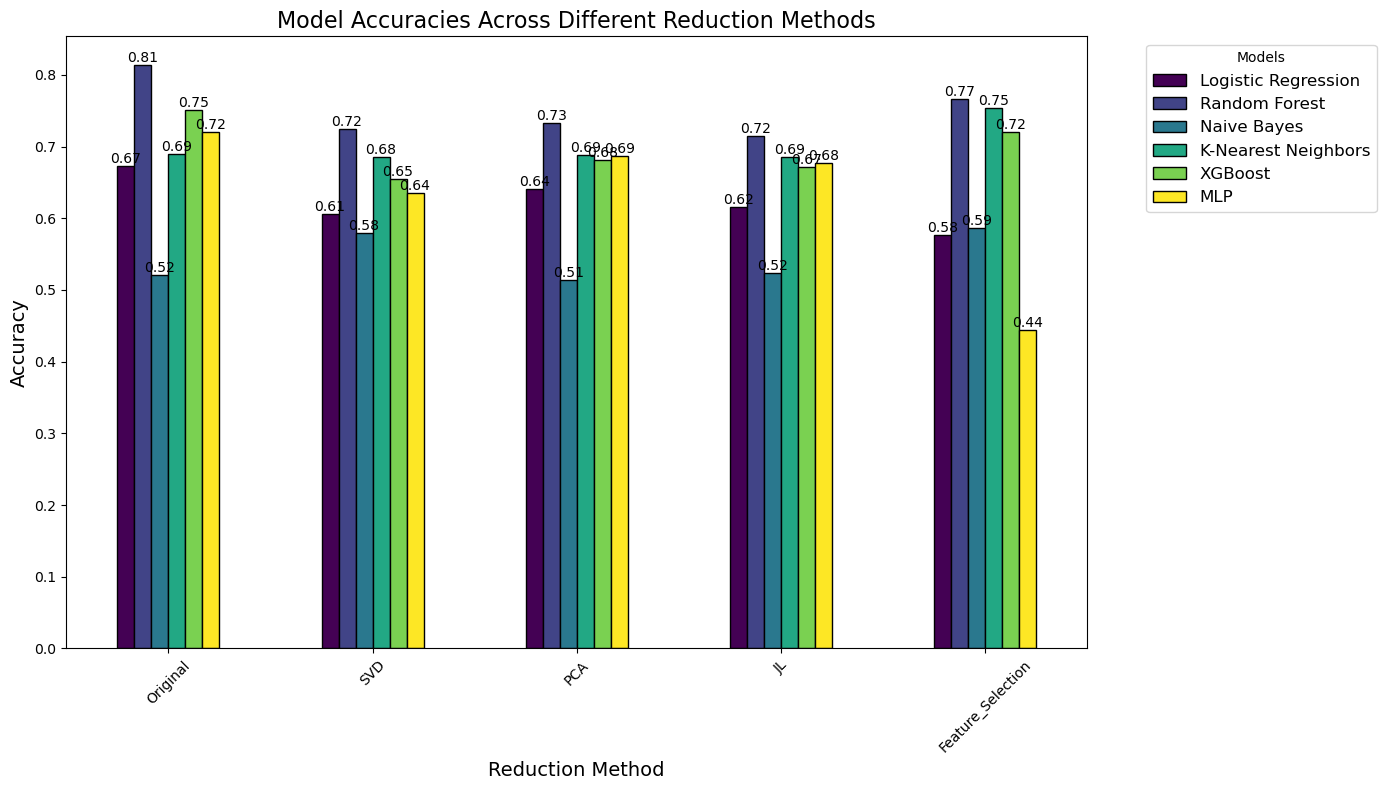

In [60]:
import matplotlib.pyplot as plt

# Extract accuracy data for plotting
accuracy_data = models_results_df.applymap(lambda x: x['accuracy'])

# Plotting
plt.figure(figsize=(12, 6))
ax = accuracy_data.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')

# Adding labels and title
plt.title('Model Accuracies Across Different Reduction Methods', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Reduction Method', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Annotating bars with accuracy values
for bar_group in ax.containers:  # Get all the bar groups
    for bar in bar_group:
        height = bar.get_height()  # Get the height of the bar (accuracy value)
        if height > 0:  # Avoid annotating bars with zero height
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position
                height,  # Y position
                f'{height:.2f}',  # Text to display
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10  # Font size
            )

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/jh/_t8scx1x6w94mv1mjlpmy5xr0000gn/T/ipykernel_94109/2900440090.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  time_data = models_results_df.applymap(lambda x: x['time'])


<Figure size 1200x600 with 0 Axes>

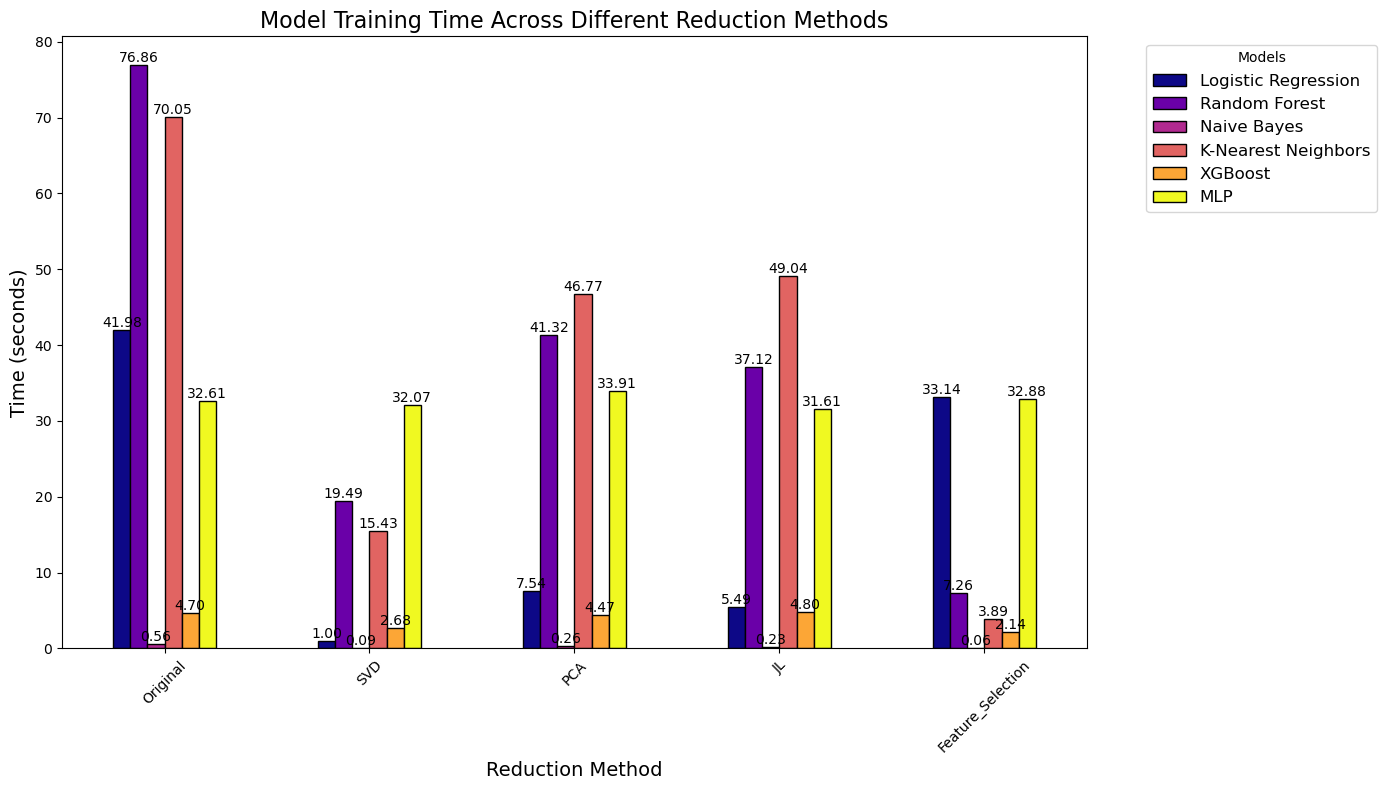

In [61]:
import matplotlib.pyplot as plt

# Extract time data for plotting
time_data = models_results_df.applymap(lambda x: x['time'])

# Plotting
plt.figure(figsize=(12, 6))
ax = time_data.plot(kind='bar', figsize=(14, 8), colormap='plasma', edgecolor='black')

# Adding labels and title
plt.title('Model Training Time Across Different Reduction Methods', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xlabel('Reduction Method', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Annotating bars with time values
for bar_group in ax.containers:  # Get all the bar groups
    for bar in bar_group:
        height = bar.get_height()  # Get the height of the bar (time value)
        if height > 0:  # Avoid annotating bars with zero height
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position
                height,  # Y position
                f'{height:.2f}',  # Text to display
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10  # Font size
            )

# Display the plot
plt.tight_layout()
plt.show()
